# Another attempt at fitting splines with PyMC3

## Setup

In [1]:
from pathlib import Path
from typing import Optional

import arviz as az
import janitor  # noqa: F401
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc as pm
import scipy.stats as st
import seaborn as sns
from aesara import tensor as at
from patsy import DesignMatrix, build_design_matrices, dmatrix

In [2]:
from speclet.io import data_dir

In [3]:
pm.__version__

'4.0.0b2'

In [4]:
# Set default theme for 'plotnine'.
gg.theme_set(gg.theme_minimal() + gg.theme(figure_size=(8, 4)))
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Constants
RANDOM_SEED = 847
HDI_PROB = 0.89

## Single spline

### Data

In [5]:
def diff_of_gaussians(
    x: np.ndarray, mus: tuple[float, float], sds: tuple[float, float], noise: float
) -> pd.DataFrame:
    y = (
        st.norm.pdf(x, mus[0], sds[0])
        - st.norm.pdf(x, mus[1], sds[1])
        + np.random.normal(0, noise, size=len(x))
    )
    return pd.DataFrame({"x": x, "y": y})

In [6]:
group_pal = {"a": "#1F77B4", "b": "#FF7F0E"}

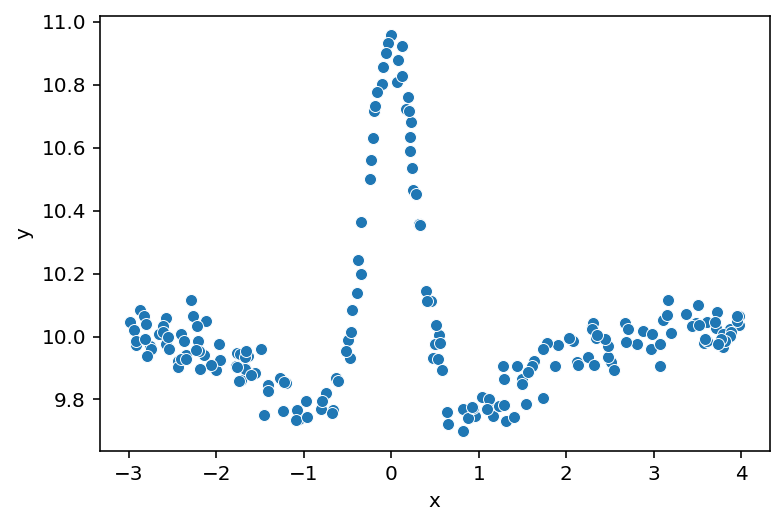

In [7]:
np.random.seed(RANDOM_SEED)

x = np.random.uniform(-3, 4, 200)
data = diff_of_gaussians(x, (0, 0), (0.3, 1), 0.05).assign(y=lambda d: d.y + 10.0)

sns.scatterplot(data=data, x="x", y="y");

### Spline basis

In [8]:
def _make_knot_list(data: pd.DataFrame, num_knots: int = 10) -> np.ndarray:
    return np.quantile(data.x, np.linspace(0, 1, num_knots))


def _build_spline(
    data: pd.DataFrame, knot_list: Optional[np.ndarray] = None, num_knots: int = 10
) -> tuple[np.ndarray, DesignMatrix]:
    if knot_list is None:
        knot_list = _make_knot_list(data, num_knots)

    B = dmatrix(
        "bs(x, knots=knots, degree=3, include_intercept=True) - 1",
        {"x": data.x.values, "knots": knot_list[1:-1]},
    )
    return knot_list, B

In [9]:
knot_list, B = _build_spline(data)

In [10]:
knot_list

array([-2.98089976, -2.36504627, -1.67490314, -0.72551484, -0.04744339,
        0.50477523,  1.30390392,  2.31655179,  3.43279987,  3.97389701])

In [11]:
B

DesignMatrix with shape (200, 12)
  Columns:
    ['bs(x, knots=knots, degree=3, include_intercept=True)[0]',
     'bs(x, knots=knots, degree=3, include_intercept=True)[1]',
     'bs(x, knots=knots, degree=3, include_intercept=True)[2]',
     'bs(x, knots=knots, degree=3, include_intercept=True)[3]',
     'bs(x, knots=knots, degree=3, include_intercept=True)[4]',
     'bs(x, knots=knots, degree=3, include_intercept=True)[5]',
     'bs(x, knots=knots, degree=3, include_intercept=True)[6]',
     'bs(x, knots=knots, degree=3, include_intercept=True)[7]',
     'bs(x, knots=knots, degree=3, include_intercept=True)[8]',
     'bs(x, knots=knots, degree=3, include_intercept=True)[9]',
     'bs(x, knots=knots, degree=3, include_intercept=True)[10]',
     'bs(x, knots=knots, degree=3, include_intercept=True)[11]']
  Terms:
    'bs(x, knots=knots, degree=3, include_intercept=True)' (columns 0:12)
  (to view full data, use np.asarray(this_obj))

In [12]:
np.asarray(B).shape

(200, 12)

In [13]:
data.shape

(200, 2)

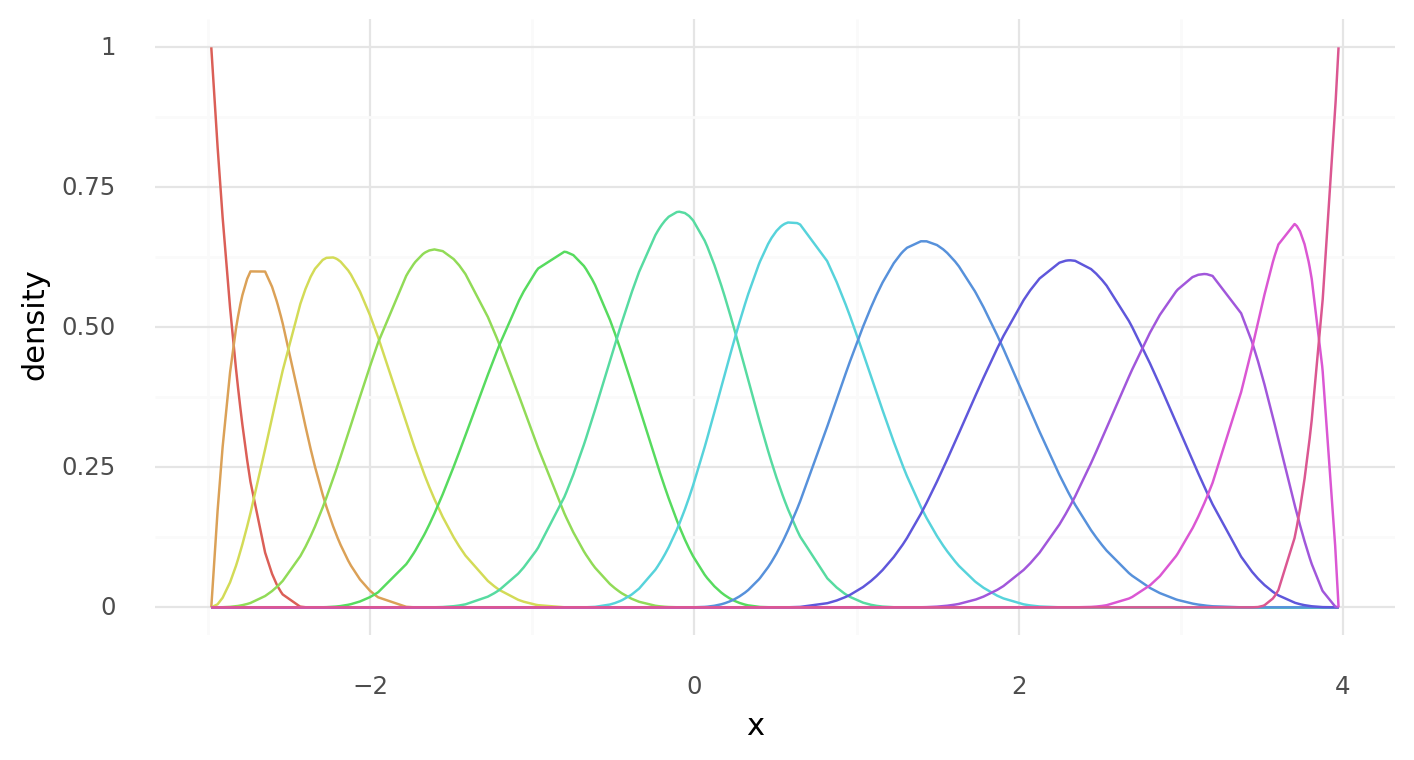

<ggplot: (338298902)>

In [14]:
basis_df = (
    pd.DataFrame(B)
    .reset_index(drop=False)
    .assign(x=data.x.values)
    .pivot_longer(index=["index", "x"], names_to="basis", values_to="density")
)

(
    gg.ggplot(basis_df, gg.aes(x="x", y="density", color="basis"))
    + gg.geom_line()
    + gg.theme(legend_position="none")
)

### Model #1

In [15]:
def build_model1(data: pd.DataFrame, B: DesignMatrix) -> pm.Model:
    B_dim = B.shape[1]

    with pm.Model(rng_seeder=RANDOM_SEED) as m1:
        w = pm.Normal("w", 0, 5, shape=B_dim)
        mu = pm.Deterministic("mu", pm.math.dot(np.asarray(B, order="F"), w.T))
        sigma = pm.Gamma("sigma", 2, 0.5)
        y = pm.Normal("y", mu, sigma, observed=data.y)

    return m1

### Prior predictive

In [16]:
def _build_new_data(
    data: pd.DataFrame, B: DesignMatrix, knots: np.ndarray, n_x: int = 500
) -> tuple[pd.DataFrame, DesignMatrix]:
    new_data = pd.DataFrame(
        {"x": np.linspace(data.x.min(), data.x.max(), num=n_x)}
    ).assign(y=0)
    new_B = build_design_matrices(
        [B.design_info], {"x": new_data.x.values, "knots": knots[1:-1]}
    )[0]
    return new_data, new_B

In [17]:
def _plot_prior(
    prior_pred: az.InferenceData, var_name: str, data: pd.DataFrame
) -> None:
    if var_name == "y":
        var_prior = prior_pred.prior_predictive[var_name].values
    else:
        var_prior = prior_pred.prior[var_name].values
    var_prior = var_prior.squeeze()
    prior_df = (
        pd.DataFrame(var_prior.T)
        .reset_index(drop=False)
        .assign(x=data.x)
        .pivot_longer(["index", "x"], names_to="prior_sample")
        .astype({"prior_sample": str})
    )

    sns.lineplot(data=prior_df, x="x", y="value", hue="prior_sample", legend=None)
    plt.show()

In [18]:
new_data, new_B = _build_new_data(data=data, B=B, knots=knot_list)

In [19]:
with build_model1(data=new_data, B=new_B):
    m1_prior_pred = pm.sample_prior_predictive(samples=10, return_inferencedata=True)

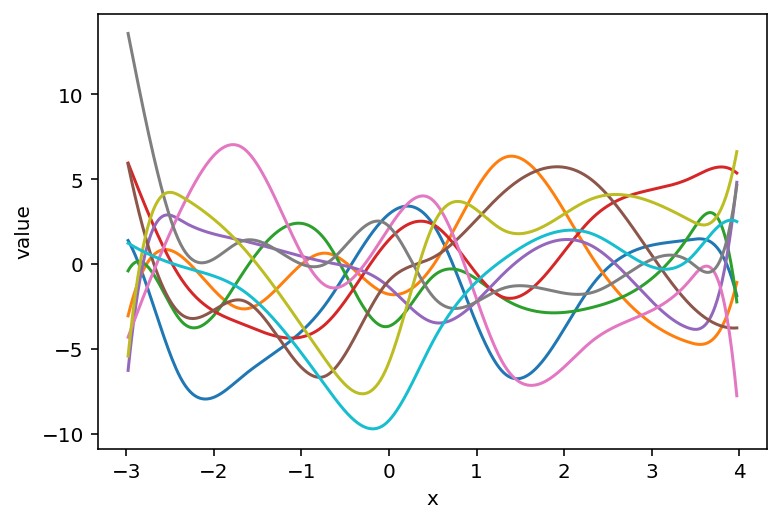

In [20]:
_plot_prior(m1_prior_pred, "mu", data=new_data)

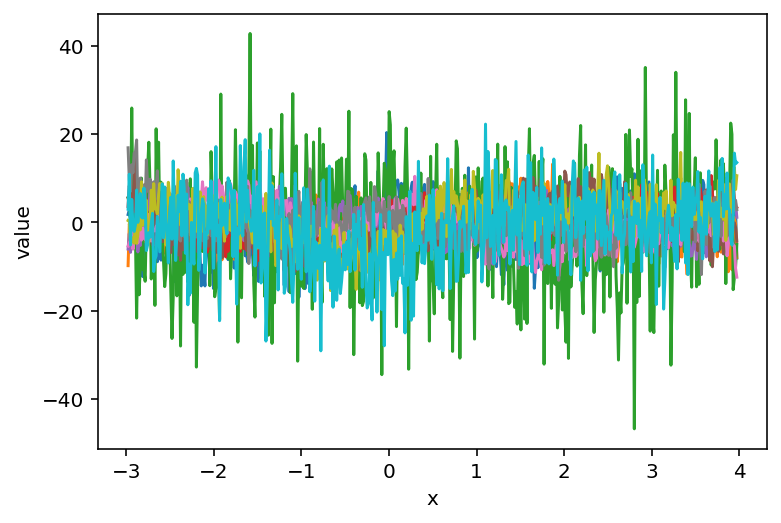

In [21]:
_plot_prior(m1_prior_pred, "y", data=new_data)

### Sample from posterior

In [22]:
pm_sample_kwargs = {
    "chains": 4,
    "cores": 4,
    "target_accept": 0.95,
    "return_inferencedata": True,
}
pm_ppc_kwargs = {"extend_inferencedata": True}

In [23]:
with build_model1(data=data, B=B):
    m1_trace = pm.sample(**pm_sample_kwargs)
    pm.sample_posterior_predictive(m1_trace, **pm_ppc_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.


### Posterior analysis

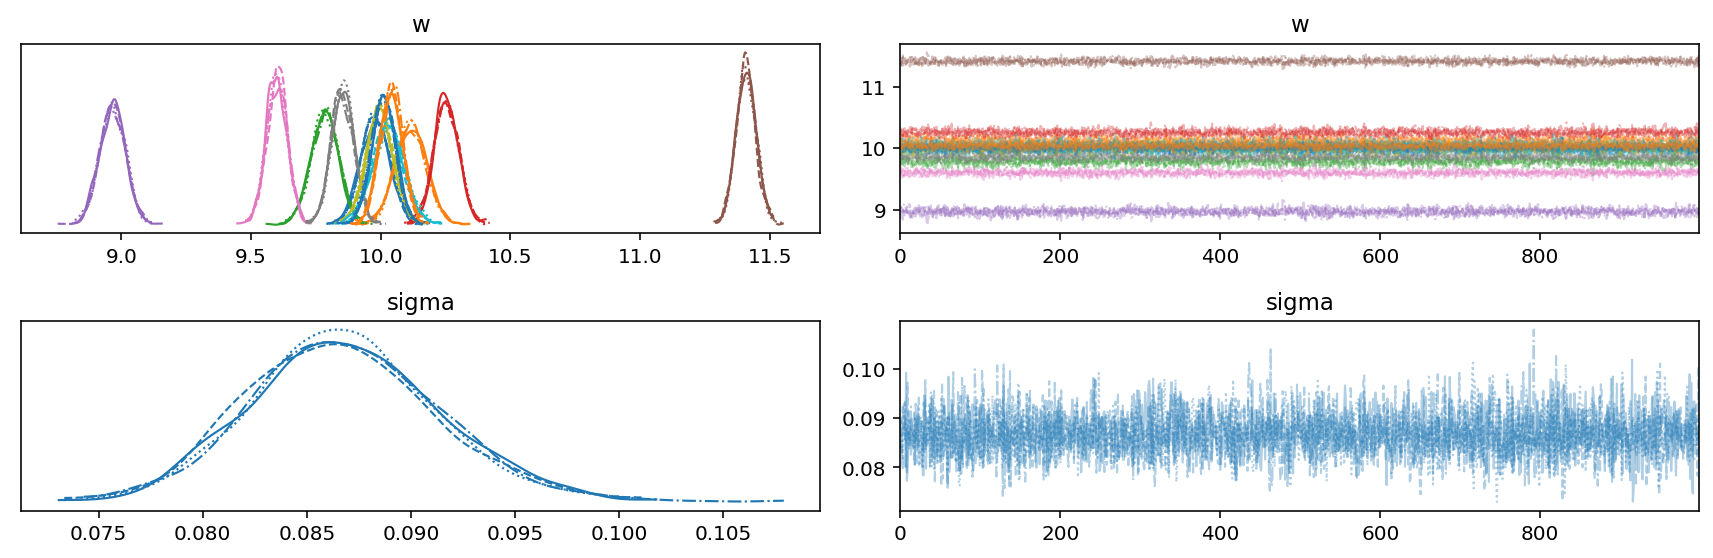

In [24]:
az.plot_trace(m1_trace, var_names=["~mu"])
plt.tight_layout();

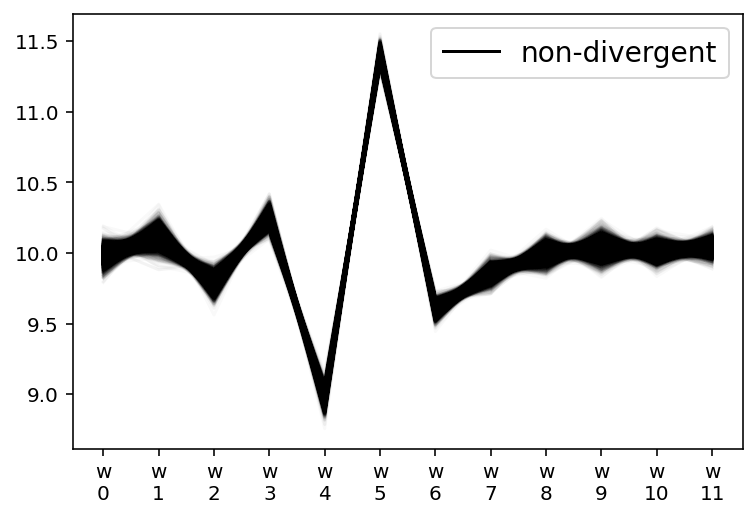

In [25]:
az.plot_parallel(m1_trace, var_names=["w"]);

In [26]:
az.summary(m1_trace, var_names=["~mu"], filter_vars="regex")

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
w[0]    9.979  0.054   9.881   10.085      0.001    0.001    3329.0    3069.0   
w[1]   10.116  0.059  10.012   10.235      0.001    0.001    2550.0    2684.0   
w[2]    9.784  0.052   9.678    9.875      0.001    0.001    2267.0    2752.0   
w[3]   10.253  0.047  10.165   10.343      0.001    0.001    2305.0    2791.0   
w[4]    8.967  0.049   8.871    9.055      0.001    0.001    2426.0    2970.0   
w[5]   11.409  0.038  11.337   11.481      0.001    0.001    2108.0    2844.0   
w[6]    9.600  0.040   9.522    9.674      0.001    0.001    2004.0    2861.0   
w[7]    9.854  0.044   9.779    9.940      0.001    0.001    2326.0    2549.0   
w[8]    9.996  0.051   9.902   10.096      0.001    0.001    2249.0    2448.0   
w[9]   10.030  0.061   9.918   10.150      0.001    0.001    2297.0    2736.0   
w[10]  10.011  0.046   9.920   10.097      0.001    0.001    2775.0    2693.0   
w[11]  10.040  0.044   9.959   10.122      0.001    0.000    4145.0    2950.0   
sigma   0.087  0.004   0.079    0.095      0.000    0.000    4637.0    3005.0   

       r_hat  
w[0]     1.0  
w[1]     1.0  
w[2]     1.0  
w[3]     1.0  
w[4]     1.0  
w[5]     1.0  
w[6]     1.0  
w[7]     1.0  
w[8]     1.0  
w[9]     1.0  
w[10]    1.0  
w[11]    1.0  
sigma    1.0

In [27]:
def _plot_posterior_mu(
    trace: az.InferenceData, data: pd.DataFrame, pt_alpha: float = 0.5
) -> gg.ggplot:
    mu_post_df = (
        az.summary(trace, var_names="mu", hdi_prob=HDI_PROB, kind="stats")
        .reset_index(drop=True)
        .merge(data.copy(), left_index=True, right_index=True)
    )

    if "k" not in data.columns:
        mu_post_df["k"] = "a"

    return (
        gg.ggplot(mu_post_df, gg.aes(x="x"))
        + gg.geom_point(gg.aes(y="y", color="k"), alpha=pt_alpha)
        + gg.geom_ribbon(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%", fill="k"), alpha=0.5)
        + gg.geom_line(gg.aes(y="mean", color="k"), size=0.5)
        + gg.scale_color_manual(group_pal)
        + gg.scale_fill_manual(group_pal)
    )

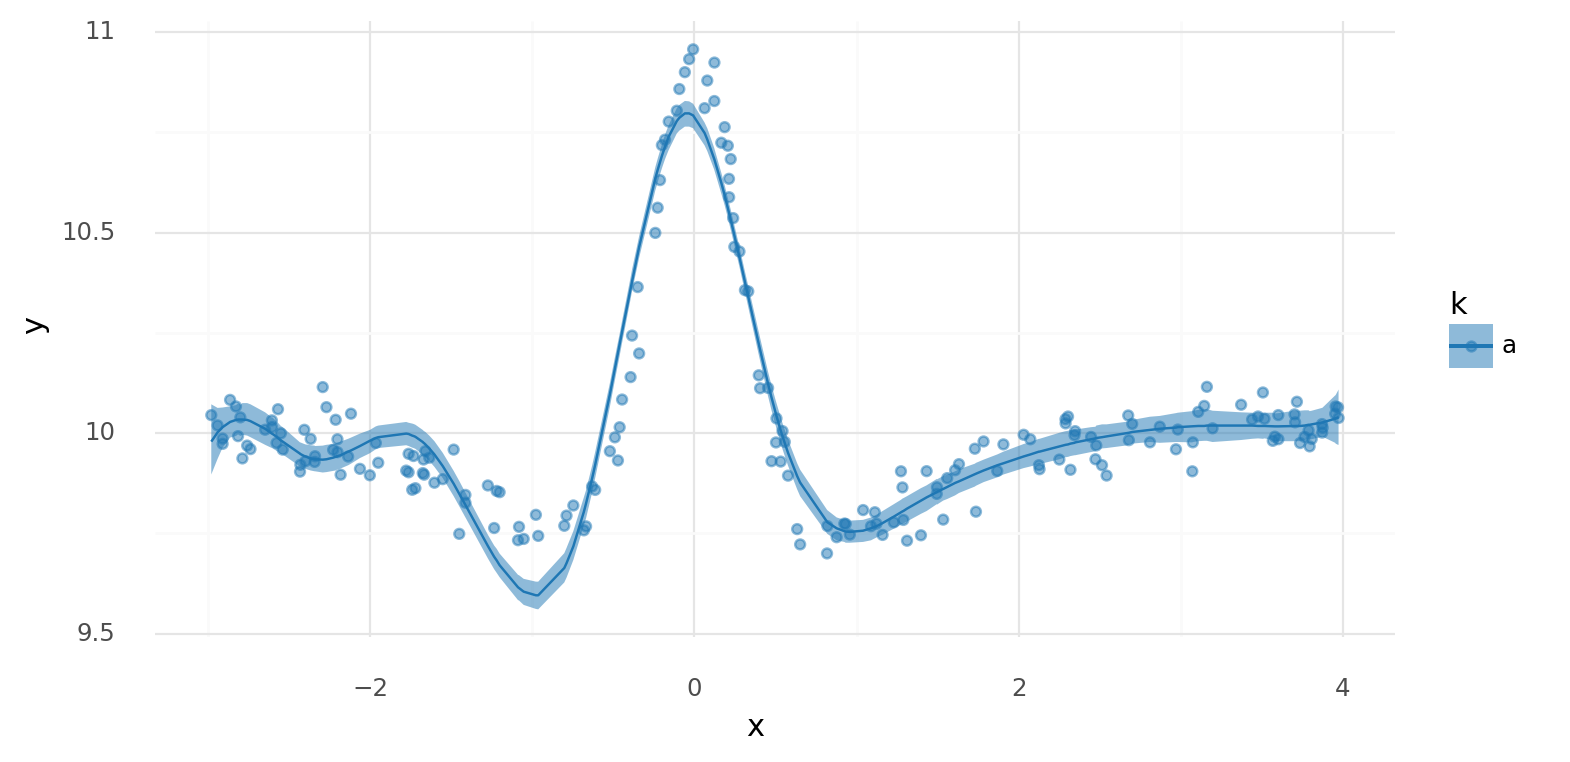

<ggplot: (342289291)>

In [28]:
_plot_posterior_mu(m1_trace, data=data)

In [29]:
def _plot_ppc(
    trace: az.InferenceData, data: pd.DataFrame, pt_alpha: float = 0.5
) -> gg.ggplot:
    post_pred = trace.posterior_predictive["y"].values.reshape(-1, data.shape[0])
    ppc_avg = post_pred.mean(0)
    ppc_hdi = az.hdi(post_pred, hdi_prob=HDI_PROB)

    plot_df = data.copy().assign(
        post_pred=ppc_avg, hdi_low=ppc_hdi[:, 0], hdi_high=ppc_hdi[:, 1]
    )

    if "k" not in data.columns:
        plot_df["k"] = np.repeat(["a"], plot_df.shape[0])

    return (
        gg.ggplot(plot_df, gg.aes(x="x"))
        + gg.geom_point(gg.aes(y="y", color="k"), alpha=pt_alpha)
        + gg.geom_ribbon(gg.aes(ymin="hdi_low", ymax="hdi_high", fill="k"), alpha=0.5)
        + gg.geom_line(gg.aes(y="post_pred", color="k"), size=1)
        + gg.scale_color_manual(group_pal)
        + gg.scale_fill_manual(group_pal)
    )

/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_48220/2876986528.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


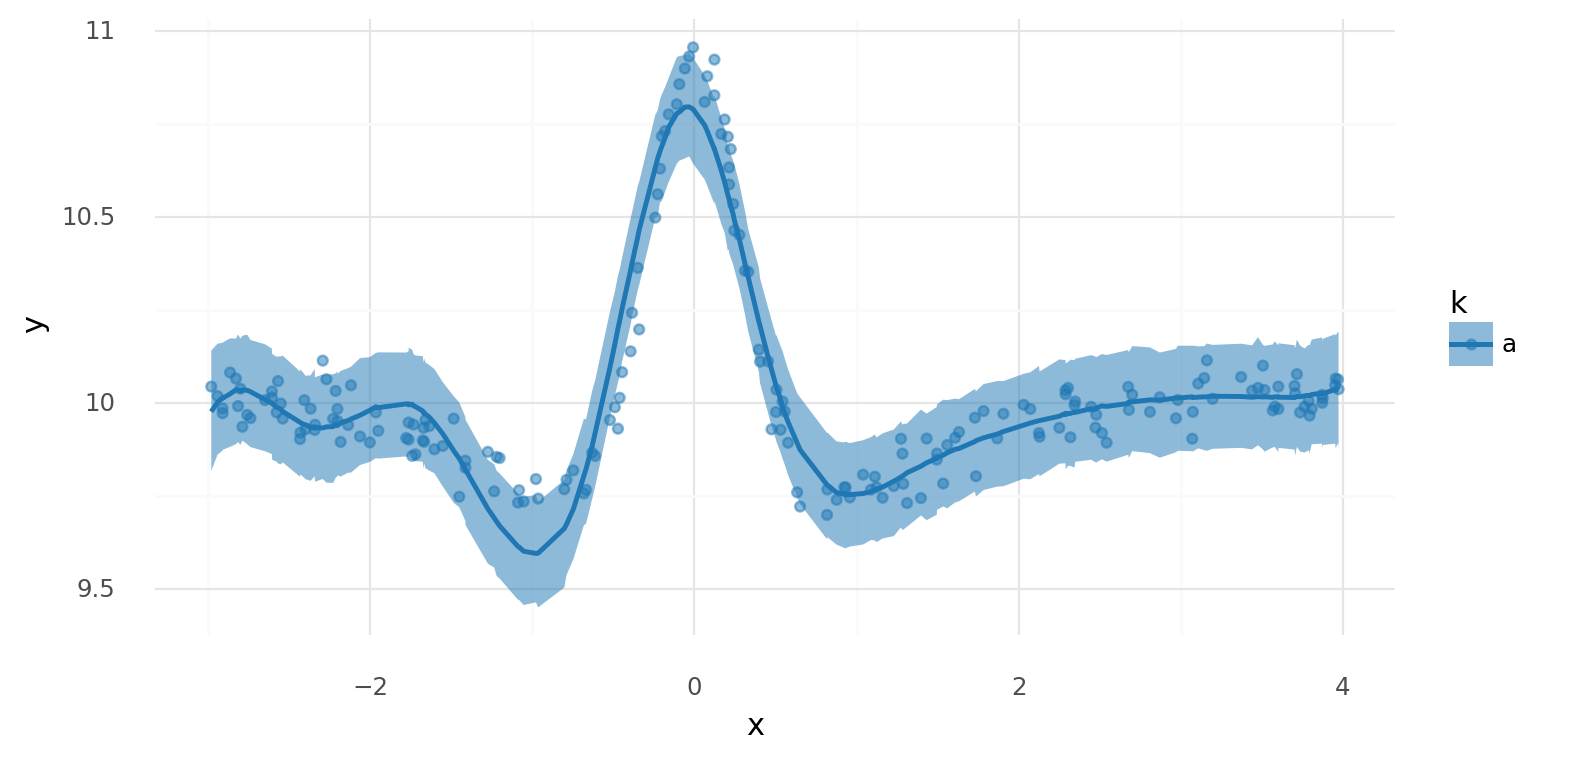

<ggplot: (342154810)>

In [30]:
_plot_ppc(m1_trace, data)

## Two groups, single spline

### Data

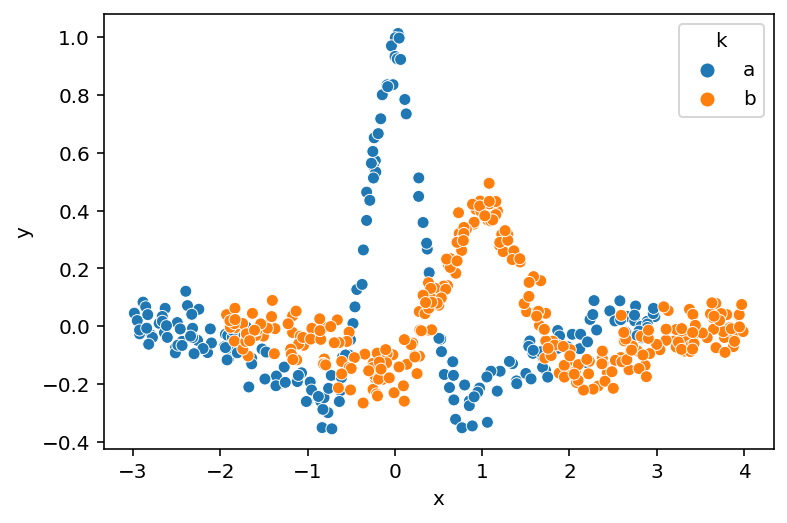

In [31]:
np.random.seed(RANDOM_SEED)

x1 = np.random.uniform(-3, 3, 200)
d1 = diff_of_gaussians(x1, (0, 0), (0.3, 1), 0.05).assign(k="a")
x2 = np.random.uniform(-3, 3, 300) + 1
d2 = diff_of_gaussians(x2, (1, 1), (0.5, 1), 0.05).assign(k="b")

data2 = pd.concat([d1, d2]).reset_index(drop=True)
data2["k"] = pd.Categorical(data2["k"], categories=["a", "b"], ordered=True)

sns.scatterplot(data=data2, x="x", y="y", hue="k", palette=group_pal);

### Spline basis

In [32]:
knot2, B2 = _build_spline(data2)

### Sample from posterior

In [33]:
with build_model1(data=data2, B=B2):
    m1_trace2 = pm.sample(**pm_sample_kwargs)
    pm.sample_posterior_predictive(m1_trace2, **pm_ppc_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


### Posterior analysis

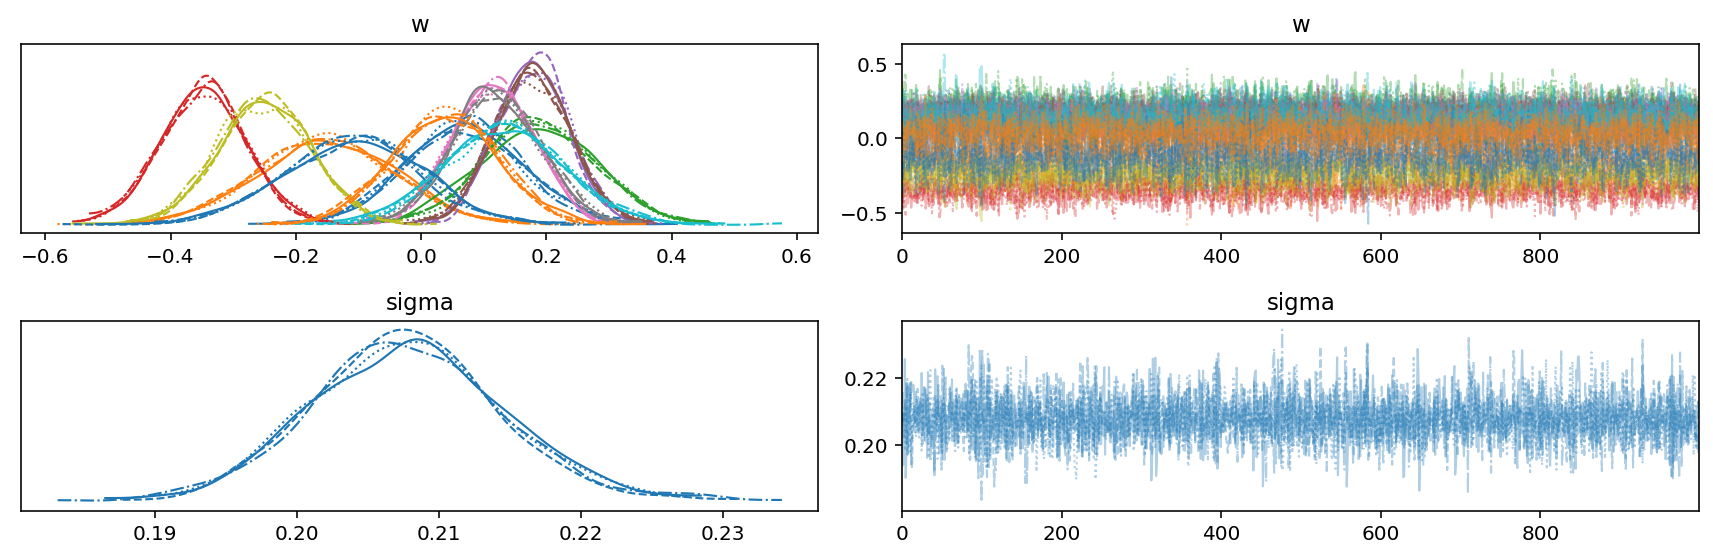

In [34]:
az.plot_trace(m1_trace2, var_names=["~mu"])
plt.tight_layout();

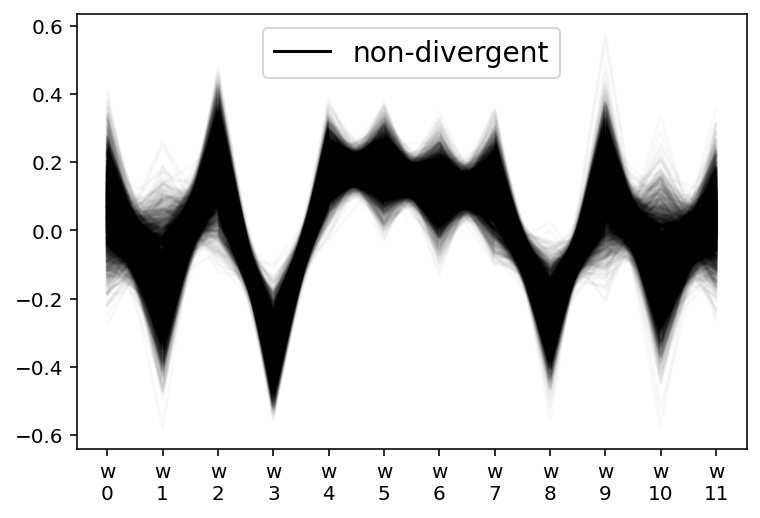

In [35]:
az.plot_parallel(m1_trace2, var_names=["w"]);

In [36]:
az.summary(m1_trace2, var_names=["~mu"], filter_vars="regex")

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
w[0]   0.069  0.094  -0.099    0.256      0.002    0.001    3031.0    2866.0   
w[1]  -0.153  0.108  -0.358    0.048      0.002    0.002    2387.0    2911.0   
w[2]   0.188  0.090   0.017    0.355      0.002    0.001    1996.0    2417.0   
w[3]  -0.348  0.068  -0.478   -0.221      0.001    0.001    2057.0    2448.0   
w[4]   0.179  0.057   0.070    0.284      0.001    0.001    2067.0    2577.0   
w[5]   0.177  0.061   0.060    0.288      0.001    0.001    2259.0    2655.0   
w[6]   0.115  0.066  -0.004    0.241      0.001    0.001    2212.0    3034.0   
w[7]   0.120  0.071  -0.010    0.254      0.002    0.001    2076.0    2620.0   
w[8]  -0.251  0.074  -0.385   -0.111      0.002    0.001    1977.0    2428.0   
w[9]   0.134  0.095  -0.042    0.320      0.002    0.001    2155.0    2753.0   
w[10] -0.109  0.108  -0.328    0.078      0.002    0.002    2123.0    2771.0   
w[11]  0.038  0.083  -0.122    0.186      0.002    0.001    3008.0    2694.0   
sigma  0.208  0.007   0.195    0.221      0.000    0.000    4826.0    2755.0   

       r_hat  
w[0]     1.0  
w[1]     1.0  
w[2]     1.0  
w[3]     1.0  
w[4]     1.0  
w[5]     1.0  
w[6]     1.0  
w[7]     1.0  
w[8]     1.0  
w[9]     1.0  
w[10]    1.0  
w[11]    1.0  
sigma    1.0

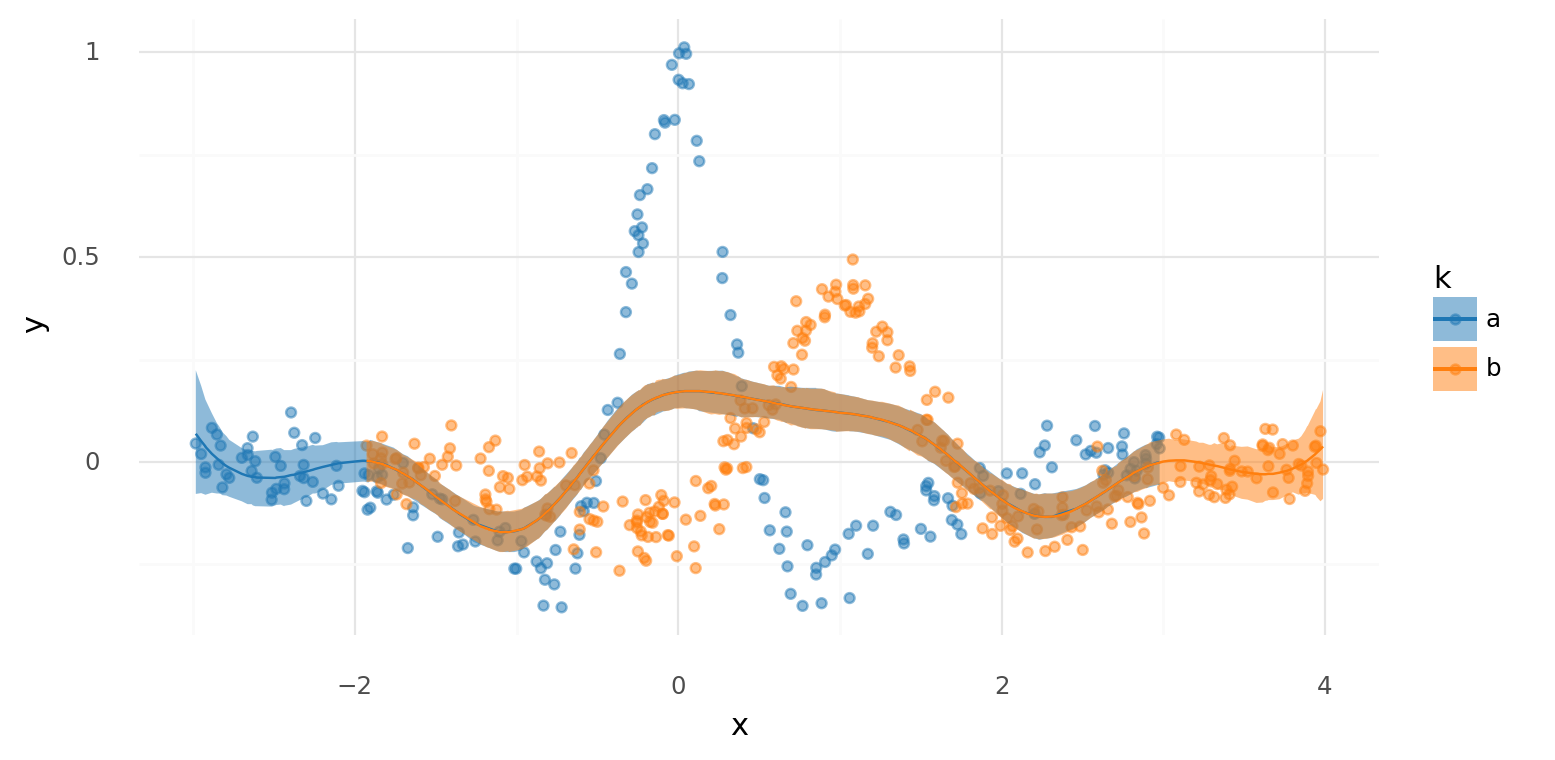

<ggplot: (341850061)>

In [37]:
_plot_posterior_mu(m1_trace2, data=data2)

/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_48220/2876986528.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


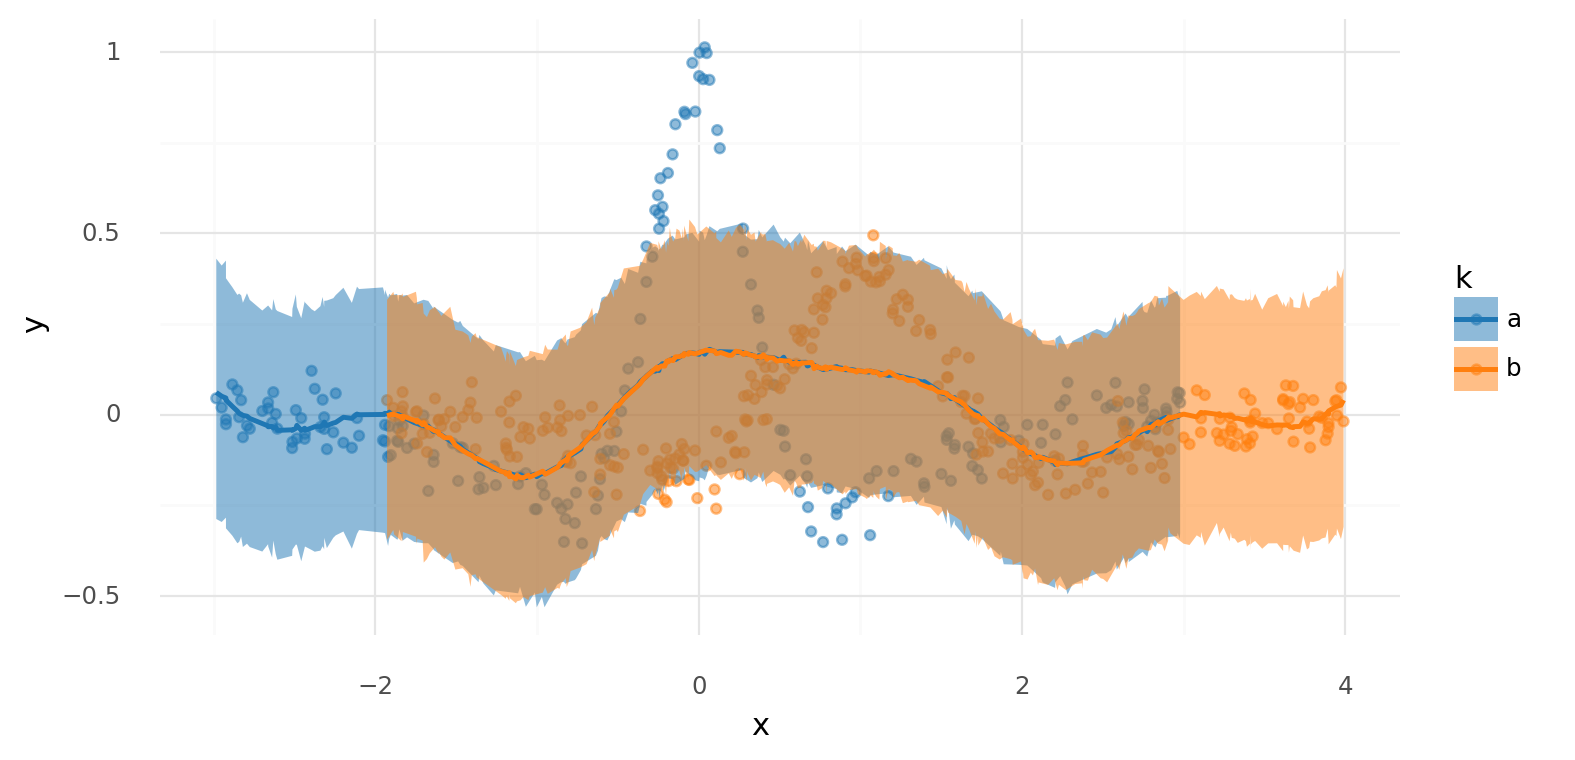

<ggplot: (341985657)>

In [38]:
_plot_ppc(m1_trace2, data2)

## Multi-group, multi-basis spline

### Spline basis

In [39]:
knots = _make_knot_list(data2)

In [40]:
spline_list: list[DesignMatrix] = []
for k in data2.k.unique():
    data_k = data2.query(f"k=='{k}'").reset_index(drop=True)
    _, B_k = _build_spline(data_k, knot_list=knots)
    spline_list.append(B_k)

print(len(spline_list))

2


In [41]:
B_k = [np.asarray(b) for b in spline_list]

In [42]:
for b in B_k:
    print(b.shape)

(200, 12)
(300, 12)


In [43]:
B_2 = np.vstack(B_k)
B_2.shape

(500, 12)

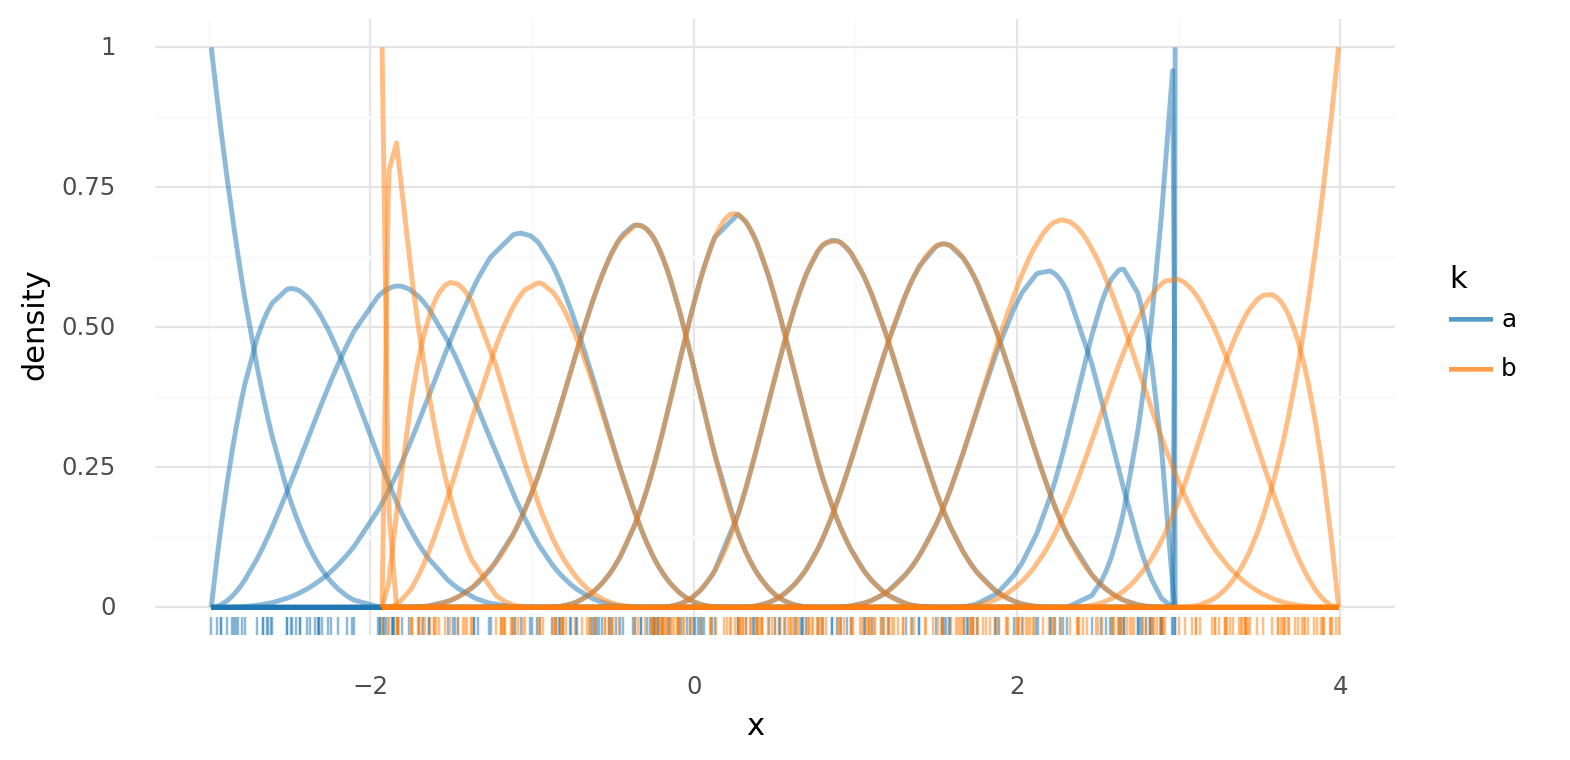

<ggplot: (341849938)>

In [44]:
basis_df = (
    pd.DataFrame(B_2)
    .assign(k=data2.k.values, x=data2.x.values)
    .pivot_longer(["k", "x"], names_to="basis", values_to="density")
    .assign(basis=lambda d: [f"{k}: {x}" for x, k in zip(d.basis, d.k)])
)
(
    gg.ggplot(basis_df, gg.aes(x="x", color="k"))
    + gg.geom_line(gg.aes(group="basis", y="density"), alpha=0.5, size=1)
    + gg.geom_rug(data=data2, alpha=0.5, sides="b")
    + gg.scale_color_manual(values=group_pal)
)

### Model #2

In [45]:
def build_model2(data: pd.DataFrame, B_k: list[np.ndarray]) -> pm.Model:
    B_dim = B_k[0].shape[1]
    k = data.k.cat.codes.values.astype(int)
    n_k = len(data.k.cat.categories)
    with pm.Model(rng_seeder=RANDOM_SEED) as m2:
        w = pm.Normal("w", 0, 5, shape=(B_dim, n_k))
        _mu = []
        for i in range(n_k):
            _mu.append(pm.math.dot(B_k[i], w[:, i]).reshape((-1, 1)))
        mu = pm.Deterministic("mu", at.vertical_stack(*_mu).squeeze())
        sigma = pm.Gamma("sigma", 2, 0.5)
        y = pm.Normal("y", mu, sigma, observed=data.y.values)

    return m2

In [46]:
m2 = build_model2(data2, B_k)
m2

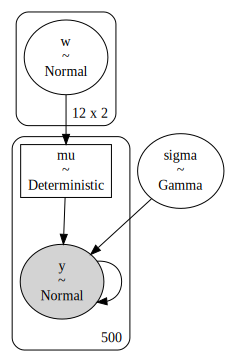

In [47]:
pm.model_to_graphviz(m2)

### Sample from posterior

In [48]:
with build_model2(data=data2, B_k=B_k):
    m2_trace = pm.sample(**pm_sample_kwargs)
    pm.sample_posterior_predictive(m2_trace, **pm_ppc_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.


### Posterior analysis

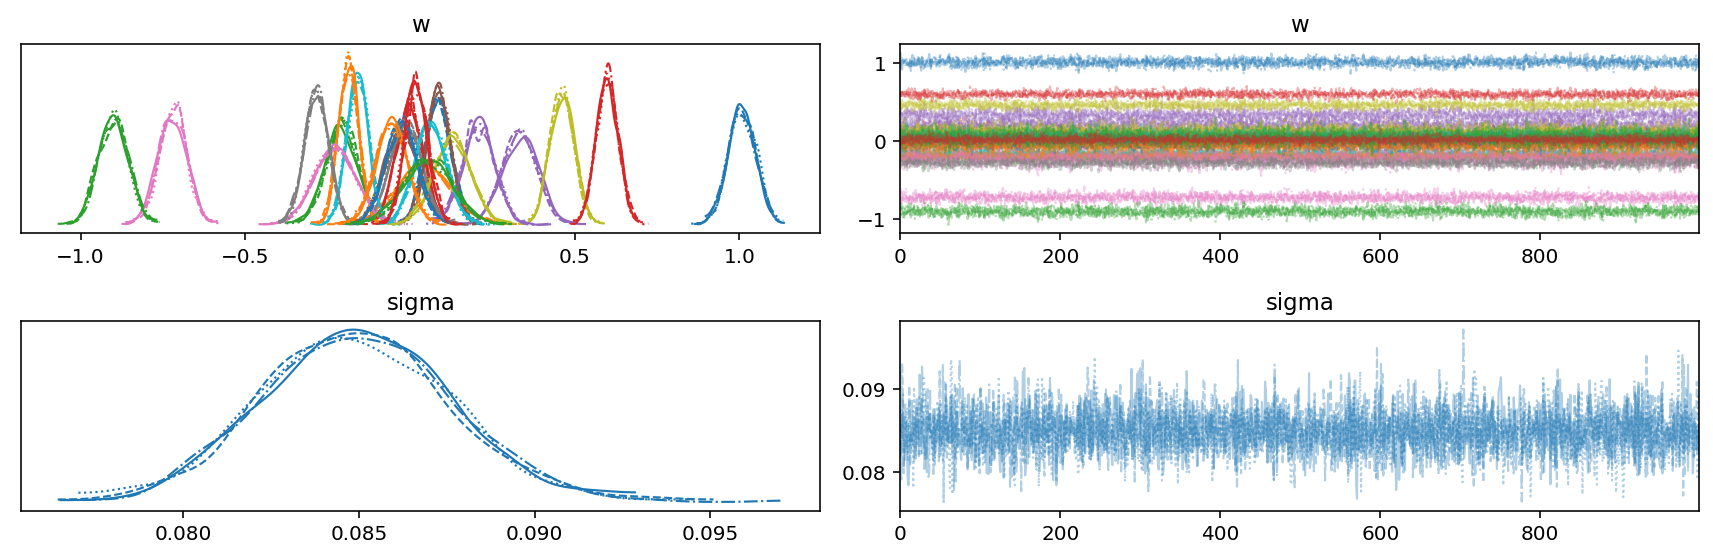

In [49]:
az.plot_trace(m2_trace, var_names=["~mu"])
plt.tight_layout();

In [50]:
az.summary(m2_trace, var_names=["~mu"], filter_vars="regex", hdi_prob=HDI_PROB)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
w[0, 0]   0.085  0.039     0.021      0.146      0.001    0.000    4357.0   
w[0, 1]   0.041  0.083    -0.098      0.169      0.001    0.001    5405.0   
w[1, 0]  -0.206  0.050    -0.283     -0.124      0.001    0.001    2691.0   
w[1, 1]  -0.002  0.040    -0.064      0.064      0.001    0.001    4212.0   
w[2, 0]   0.334  0.053     0.248      0.416      0.001    0.001    2655.0   
w[2, 1]  -0.025  0.052    -0.103      0.061      0.001    0.001    2850.0   
w[3, 0]  -0.720  0.043    -0.786     -0.650      0.001    0.001    2785.0   
w[3, 1]  -0.012  0.047    -0.092      0.059      0.001    0.001    2972.0   
w[4, 0]   0.462  0.036     0.403      0.518      0.001    0.000    2821.0   
w[4, 1]  -0.159  0.032    -0.209     -0.106      0.001    0.000    2623.0   
w[5, 0]   1.008  0.042     0.947      1.079      0.001    0.001    2884.0   
w[5, 1]  -0.186  0.030    -0.238     -0.141      0.001    0.000    2730.0   
w[6, 0]  -0.901  0.045    -0.969     -0.827      0.001    0.001    2937.0   
w[6, 1]   0.599  0.033     0.548      0.652      0.001    0.000    2400.0   
w[7, 0]   0.209  0.048     0.133      0.289      0.001    0.001    3042.0   
w[7, 1]   0.087  0.036     0.029      0.143      0.001    0.001    2475.0   
w[8, 0]  -0.227  0.062    -0.326     -0.129      0.001    0.001    3079.0   
w[8, 1]  -0.284  0.036    -0.341     -0.225      0.001    0.001    2342.0   
w[9, 0]   0.129  0.056     0.041      0.219      0.001    0.001    2793.0   
w[9, 1]   0.063  0.048    -0.013      0.139      0.001    0.001    2609.0   
w[10, 0] -0.026  0.047    -0.103      0.050      0.001    0.001    3451.0   
w[10, 1] -0.056  0.047    -0.133      0.018      0.001    0.001    2899.0   
w[11, 0]  0.055  0.074    -0.055      0.181      0.001    0.001    4940.0   
w[11, 1]  0.019  0.035    -0.033      0.077      0.001    0.000    4039.0   
sigma     0.085  0.003     0.081      0.089      0.000    0.000    4954.0   

          ess_tail  r_hat  
w[0, 0]     3511.0    1.0  
w[0, 1]     3014.0    1.0  
w[1, 0]     2735.0    1.0  
w[1, 1]     3464.0    1.0  
w[2, 0]     2696.0    1.0  
w[2, 1]     2947.0    1.0  
w[3, 0]     2916.0    1.0  
w[3, 1]     3135.0    1.0  
w[4, 0]     2896.0    1.0  
w[4, 1]     2691.0    1.0  
w[5, 0]     3114.0    1.0  
w[5, 1]     2734.0    1.0  
w[6, 0]     3131.0    1.0  
w[6, 1]     2520.0    1.0  
w[7, 0]     3112.0    1.0  
w[7, 1]     2642.0    1.0  
w[8, 0]     2924.0    1.0  
w[8, 1]     2276.0    1.0  
w[9, 0]     2965.0    1.0  
w[9, 1]     2630.0    1.0  
w[10, 0]    2897.0    1.0  
w[10, 1]    2713.0    1.0  
w[11, 0]    3193.0    1.0  
w[11, 1]    3422.0    1.0  
sigma       2803.0    1.0

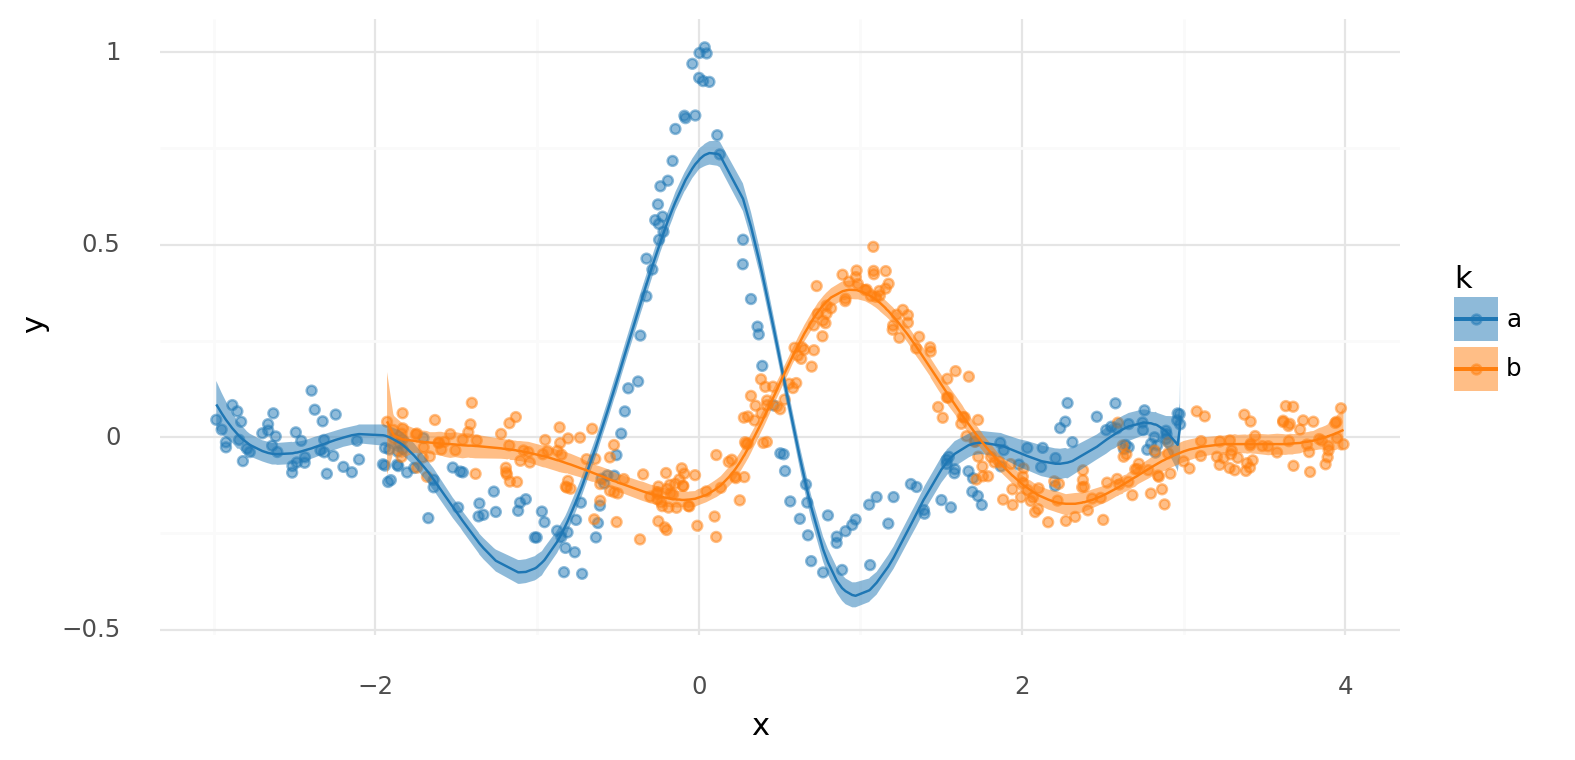

<ggplot: (342165995)>

In [51]:
_plot_posterior_mu(m2_trace, data=data2)

/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_48220/2876986528.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


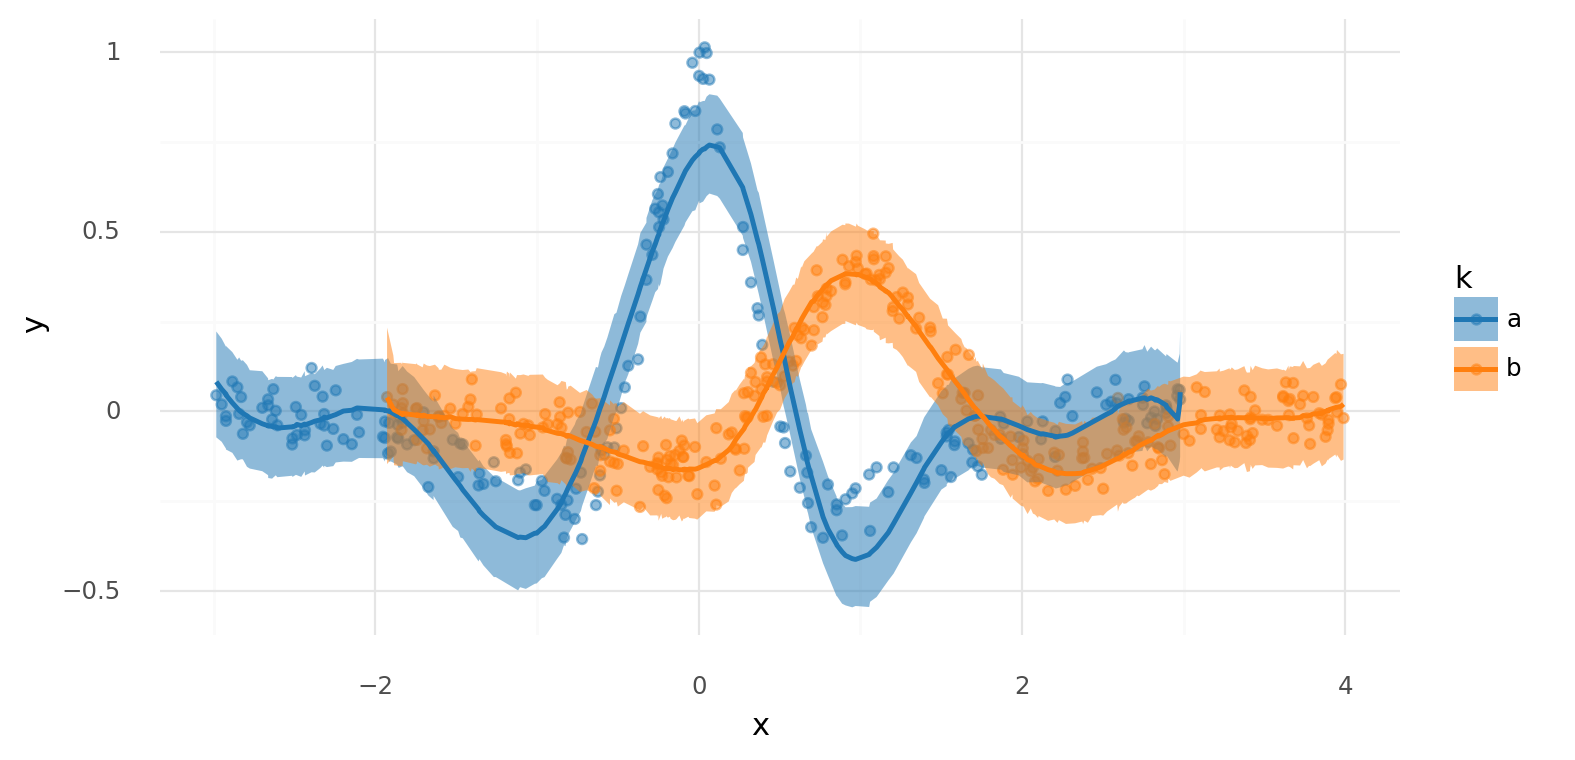

<ggplot: (340057631)>

In [52]:
_plot_ppc(m2_trace, data2)

## Multi-group, single spline basis

### Spline basis

In [53]:
knot3, B3 = _build_spline(data2)

### Model #3

In [54]:
def build_model3(data: pd.DataFrame, B: np.ndarray) -> pm.Model:
    B_dim = B.shape[1]
    k = data.k.cat.codes.values.astype(int)
    n_k = len(data.k.cat.categories)
    with pm.Model(rng_seeder=RANDOM_SEED) as m3:
        w = pm.Normal("w", 0, 5, shape=(B_dim, n_k))
        _mu = []
        for i in range(n_k):
            _mu.append(pm.math.dot(B[k == i], w[:, i]).reshape((-1, 1)))
        mu = pm.Deterministic("mu", at.vertical_stack(*_mu).squeeze())
        sigma = pm.Gamma("sigma", 2, 0.5)
        y = pm.Normal("y", mu, sigma, observed=data.y.values)

    return m3

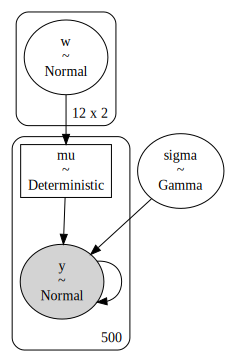

In [55]:
m3 = build_model3(data2, B3)
pm.model_to_graphviz(m3)

### Sample from posterior

In [56]:
with build_model3(data=data2, B=np.asarray(B3)):
    m3_trace = pm.sample(**pm_sample_kwargs)
    pm.sample_posterior_predictive(m3_trace, **pm_ppc_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 89 seconds.


### Posterior analysis

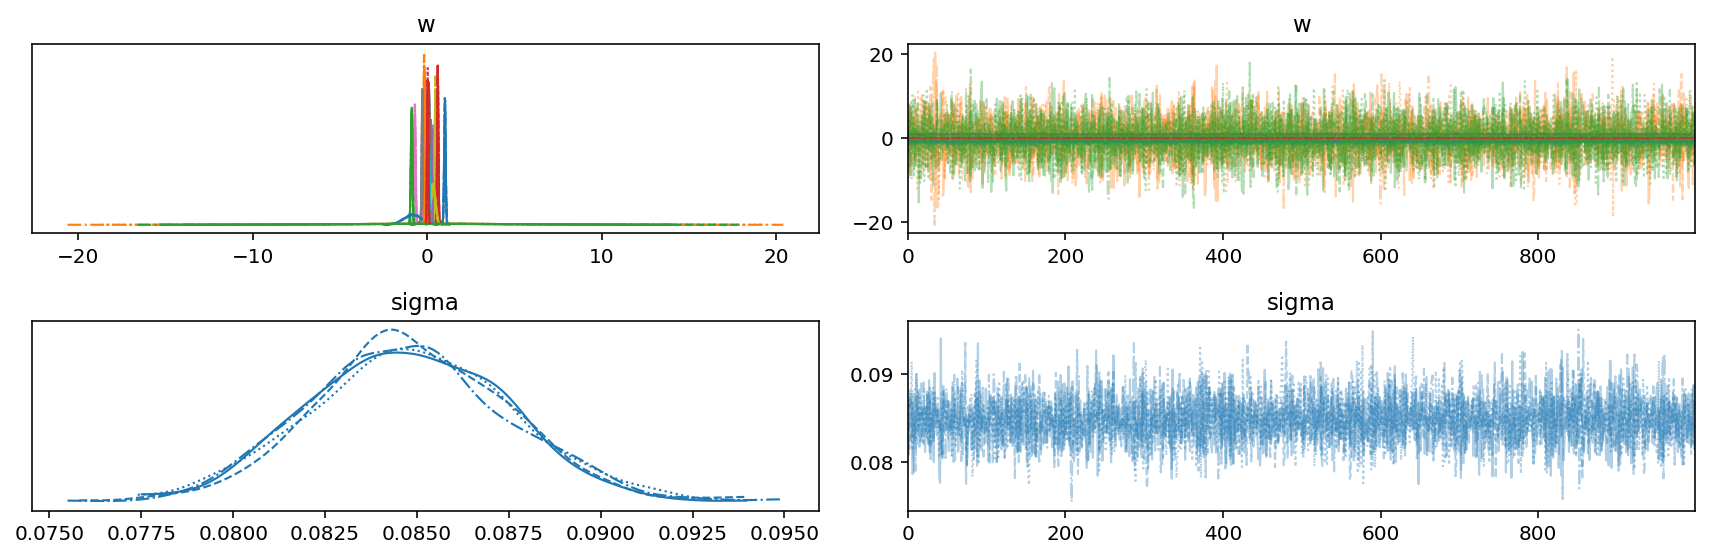

In [57]:
az.plot_trace(m3_trace, var_names=["~mu"])
plt.tight_layout();

In [58]:
az.summary(m3_trace, var_names=["~mu"], filter_vars="regex", hdi_prob=HDI_PROB)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
w[0, 0]   0.084  0.038     0.024      0.144      0.001    0.000    4048.0   
w[0, 1]  -0.066  5.136    -7.754      8.327      0.067    0.102    5854.0   
w[1, 0]  -0.204  0.050    -0.281     -0.119      0.001    0.001    3205.0   
w[1, 1]   0.161  0.322    -0.331      0.696      0.006    0.005    2667.0   
w[2, 0]   0.333  0.053     0.247      0.415      0.001    0.001    2836.0   
w[2, 1]  -0.049  0.102    -0.206      0.117      0.002    0.002    2432.0   
w[3, 0]  -0.721  0.044    -0.790     -0.653      0.001    0.001    2933.0   
w[3, 1]  -0.008  0.046    -0.081      0.061      0.001    0.001    2366.0   
w[4, 0]   0.463  0.037     0.408      0.523      0.001    0.000    2759.0   
w[4, 1]  -0.160  0.032    -0.210     -0.108      0.001    0.000    2445.0   
w[5, 0]   1.007  0.042     0.937      1.072      0.001    0.001    2817.0   
w[5, 1]  -0.186  0.030    -0.237     -0.140      0.001    0.000    2820.0   
w[6, 0]  -0.898  0.045    -0.969     -0.825      0.001    0.001    2597.0   
w[6, 1]   0.600  0.033     0.549      0.652      0.001    0.000    2595.0   
w[7, 0]   0.203  0.049     0.128      0.282      0.001    0.001    2928.0   
w[7, 1]   0.086  0.036     0.031      0.142      0.001    0.001    2522.0   
w[8, 0]  -0.214  0.061    -0.304     -0.111      0.001    0.001    2468.0   
w[8, 1]  -0.283  0.037    -0.339     -0.221      0.001    0.001    2428.0   
w[9, 0]   0.336  0.121     0.144      0.528      0.002    0.002    2397.0   
w[9, 1]   0.062  0.047    -0.014      0.137      0.001    0.001    2498.0   
w[10, 0] -0.841  0.494    -1.594     -0.038      0.009    0.007    2755.0   
w[10, 1] -0.056  0.046    -0.131      0.015      0.001    0.001    2811.0   
w[11, 0] -0.013  4.928    -7.766      8.025      0.064    0.080    5892.0   
w[11, 1]  0.020  0.034    -0.033      0.077      0.001    0.000    3872.0   
sigma     0.085  0.003     0.081      0.089      0.000    0.000    5743.0   

          ess_tail  r_hat  
w[0, 0]     3059.0    1.0  
w[0, 1]     2886.0    1.0  
w[1, 0]     2743.0    1.0  
w[1, 1]     2811.0    1.0  
w[2, 0]     2778.0    1.0  
w[2, 1]     2497.0    1.0  
w[3, 0]     2882.0    1.0  
w[3, 1]     2853.0    1.0  
w[4, 0]     3108.0    1.0  
w[4, 1]     2873.0    1.0  
w[5, 0]     2722.0    1.0  
w[5, 1]     2434.0    1.0  
w[6, 0]     2852.0    1.0  
w[6, 1]     2879.0    1.0  
w[7, 0]     3057.0    1.0  
w[7, 1]     2895.0    1.0  
w[8, 0]     3033.0    1.0  
w[8, 1]     2987.0    1.0  
w[9, 0]     2370.0    1.0  
w[9, 1]     3171.0    1.0  
w[10, 0]    2897.0    1.0  
w[10, 1]    3079.0    1.0  
w[11, 0]    3280.0    1.0  
w[11, 1]    3116.0    1.0  
sigma       2925.0    1.0

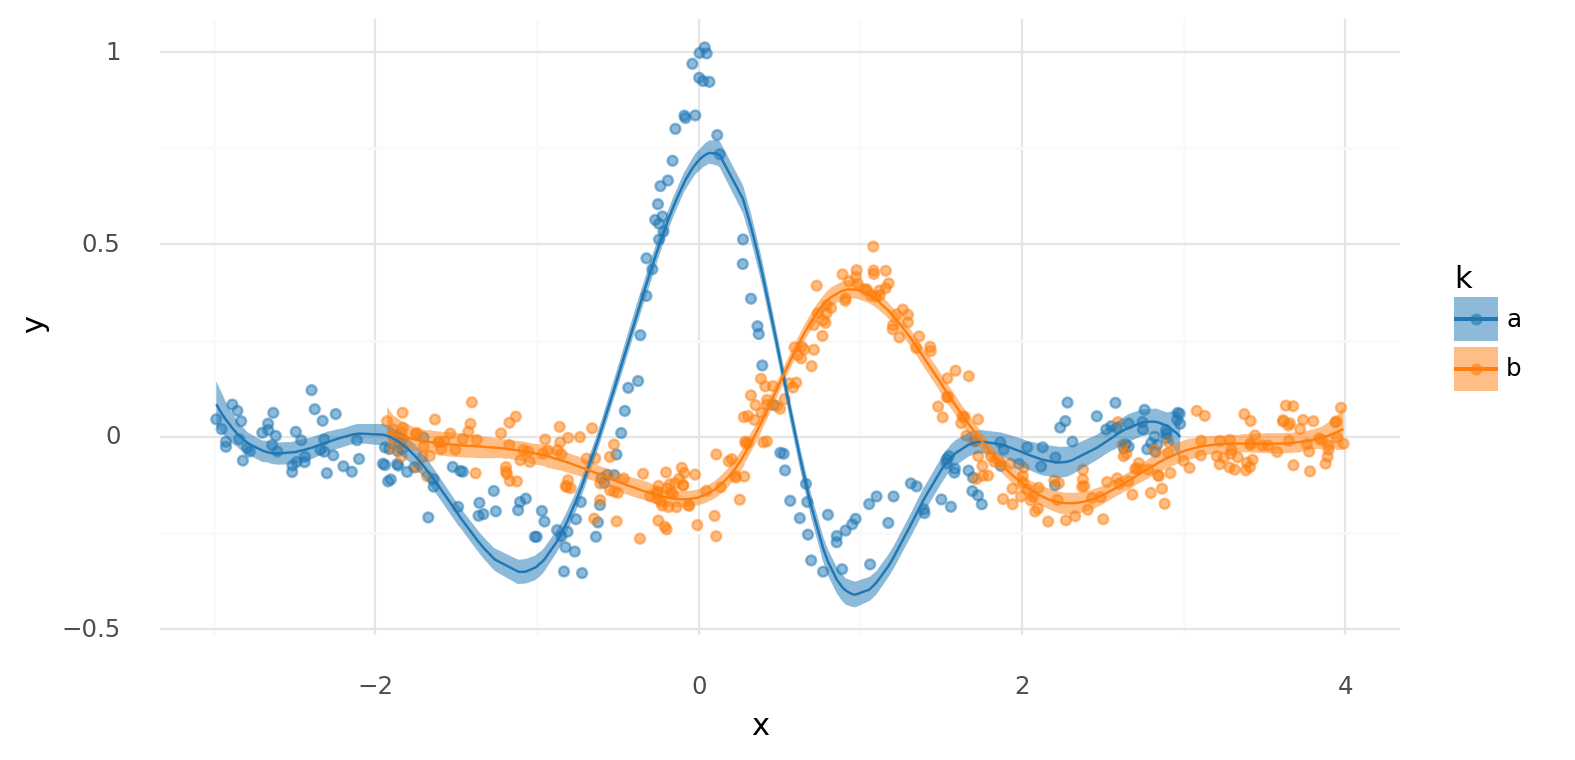

<ggplot: (339816515)>

In [59]:
_plot_posterior_mu(m3_trace, data=data2)

/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_48220/2876986528.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


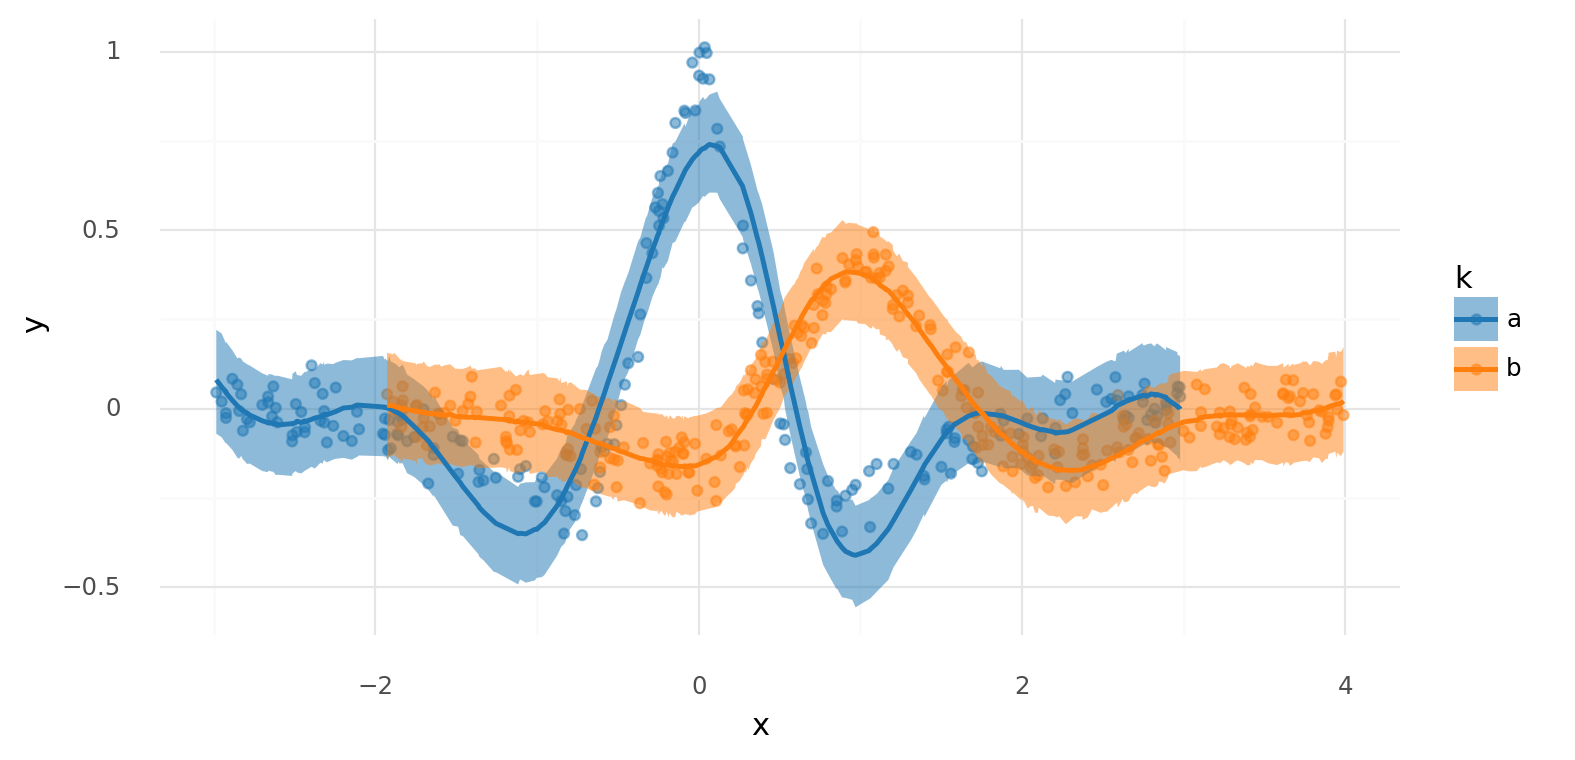

<ggplot: (339079141)>

In [60]:
_plot_ppc(m3_trace, data2)

### Out-of-distribution predictions

In [61]:
new_data3, new_B3 = _build_new_data(data2, B=B3, knots=knot3, n_x=500)
new_data3 = pd.concat([new_data3.assign(k=k) for k in ["a", "b"]]).reset_index(
    drop=True
)
new_data3["k"] = pd.Categorical(new_data3["k"], categories=["a", "b"], ordered=True)
new_B3_array = np.vstack([np.asarray(new_B3) for _ in ["a", "b"]])

In [62]:
with build_model3(new_data3, B=new_B3_array):
    m3_post_pred_new = pm.sample_posterior_predictive(
        trace=m3_trace,
        var_names=["mu", "y"],
        return_inferencedata=True,
        extend_inferencedata=False,
    )

/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_48220/2876986528.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


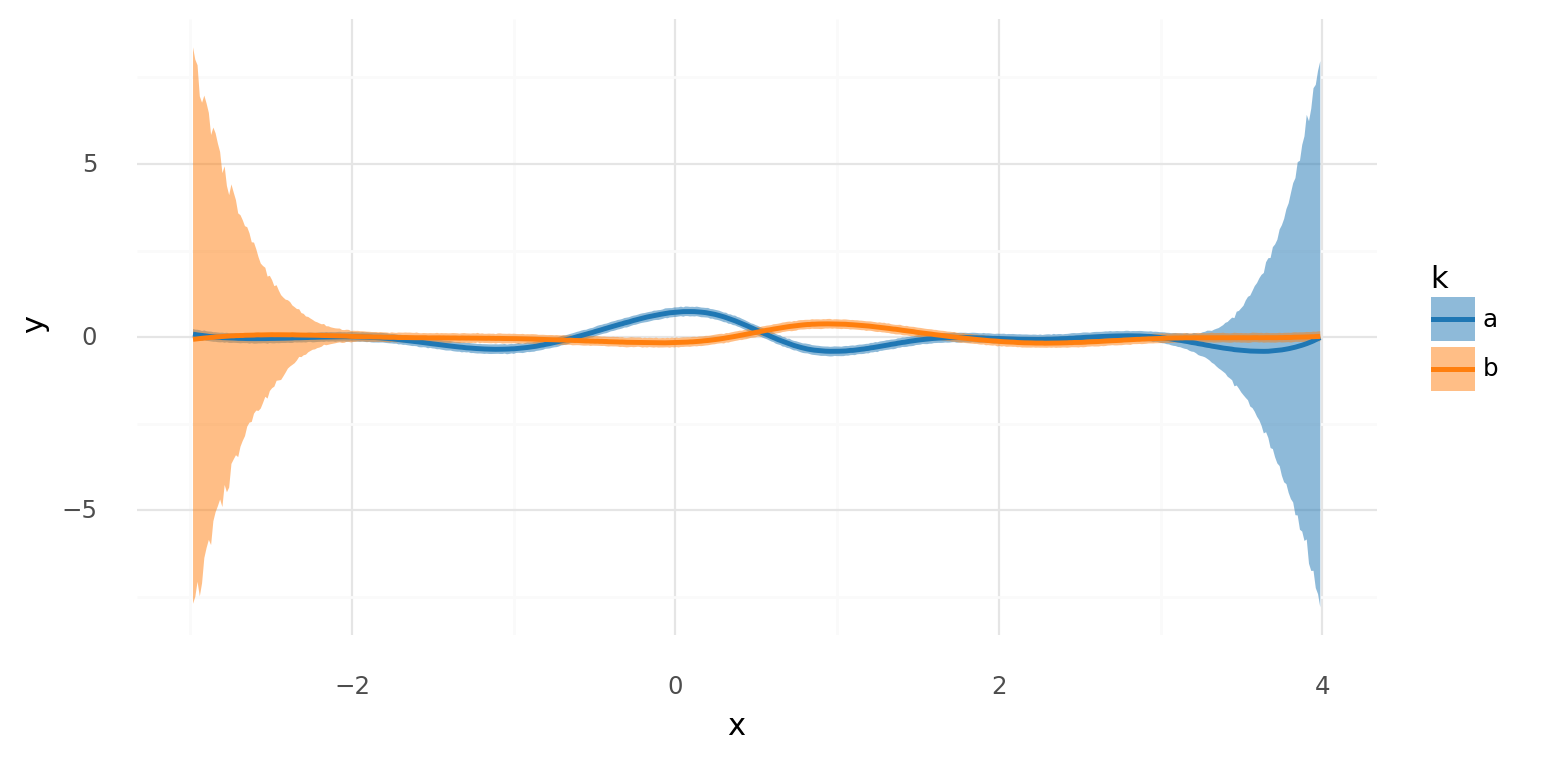

<ggplot: (340039132)>

In [63]:
_plot_ppc(m3_post_pred_new, new_data3, pt_alpha=0)

## Hierarchical prior on multi-group spline

### Model #4

In [64]:
def build_model4(data: pd.DataFrame, B: np.ndarray) -> pm.Model:
    B_dim = B.shape[1]
    k = data.k.cat.codes.values.astype(int)
    n_k = len(data.k.cat.categories)
    with pm.Model(rng_seeder=RANDOM_SEED) as m4:
        mu_w = pm.StudentT("mu_w", nu=5, mu=0, sigma=5, shape=(B_dim, 1))
        sigma_w = pm.Gamma("sigma_w", 2.0, 0.5)
        w = pm.Normal(
            "w",
            at.horizontal_stack(*[mu_w for _ in range(n_k)]),
            sigma_w,
            shape=(B_dim, n_k),
        )
        _mu = []
        for i in range(n_k):
            _mu.append(pm.math.dot(B[k == i], w[:, i]).reshape((-1, 1)))
        mu = pm.Deterministic("mu", at.vertical_stack(*_mu).squeeze())
        sigma = pm.Gamma("sigma", 2, 0.5)
        y = pm.Normal("y", mu, sigma, observed=data.y.values)

    return m4

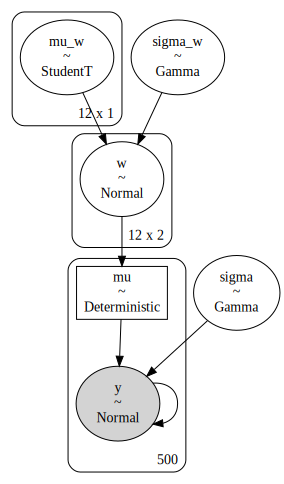

In [65]:
m4 = build_model4(data2, B3)
pm.model_to_graphviz(m4)

### Sample from posterior

In [66]:
with build_model4(data=data2, B=np.asarray(B3)):
    m4_trace = pm.sample(**pm_sample_kwargs)
    pm.sample_posterior_predictive(m4_trace, **pm_ppc_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_w, sigma_w, w, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 96 seconds.


### Posterior analysis

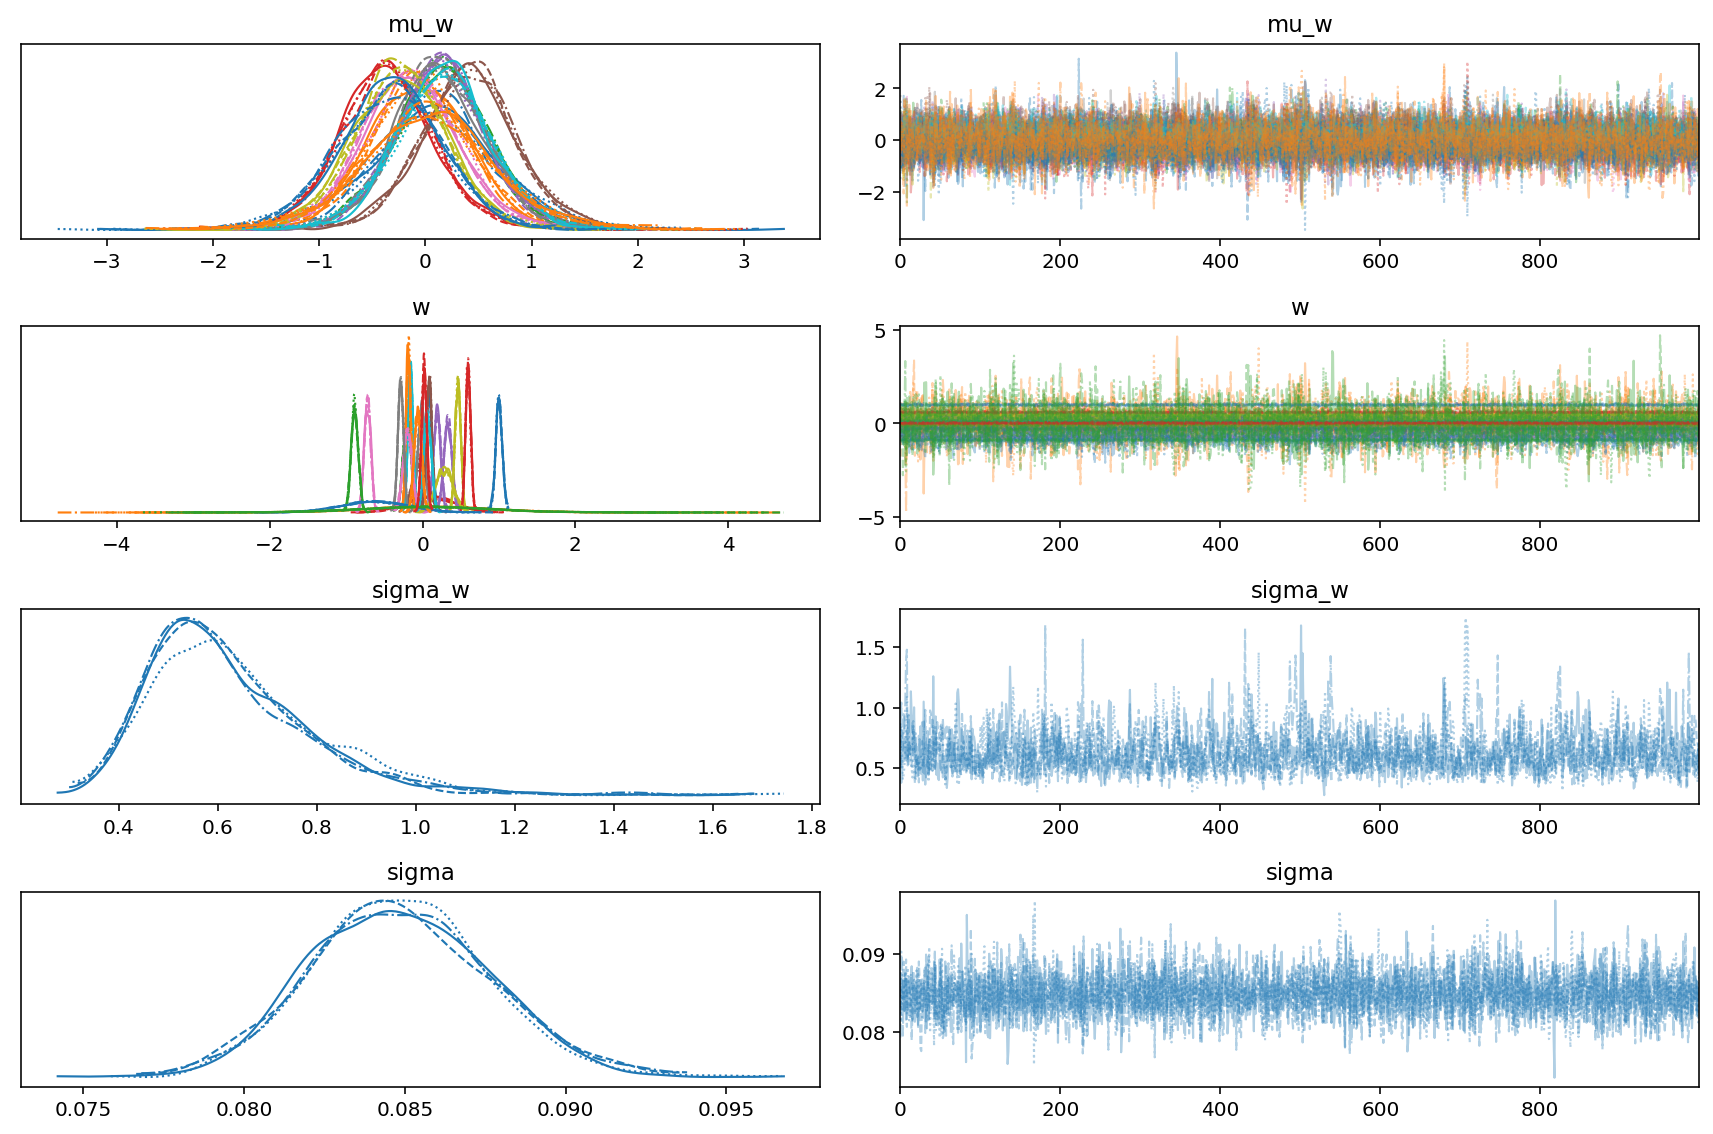

In [67]:
az.plot_trace(m4_trace, var_names=["~mu"])
plt.tight_layout();

In [68]:
az.summary(m4_trace, var_names=["~mu"], filter_vars="regex", hdi_prob=HDI_PROB)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
w[0, 0]   0.084  0.039     0.022      0.144      0.001    0.000    3798.0   
w[0, 1]   0.067  0.903    -1.364      1.432      0.014    0.015    4170.0   
w[1, 0]  -0.203  0.051    -0.284     -0.125      0.001    0.001    3241.0   
w[1, 1]   0.095  0.304    -0.355      0.621      0.006    0.004    2951.0   
w[2, 0]   0.332  0.052     0.251      0.420      0.001    0.001    3025.0   
w[2, 1]  -0.029  0.096    -0.184      0.123      0.002    0.001    2692.0   
w[3, 0]  -0.720  0.042    -0.789     -0.654      0.001    0.001    3244.0   
w[3, 1]  -0.015  0.045    -0.086      0.057      0.001    0.001    2895.0   
w[4, 0]   0.464  0.036     0.406      0.520      0.001    0.000    3260.0   
w[4, 1]  -0.158  0.032    -0.210     -0.108      0.001    0.000    3248.0   
w[5, 0]   1.001  0.042     0.939      1.075      0.001    0.001    3198.0   
w[5, 1]  -0.185  0.029    -0.230     -0.137      0.001    0.000    3279.0   
w[6, 0]  -0.888  0.046    -0.960     -0.815      0.001    0.001    3227.0   
w[6, 1]   0.597  0.033     0.547      0.650      0.001    0.000    2934.0   
w[7, 0]   0.190  0.048     0.119      0.271      0.001    0.001    2809.0   
w[7, 1]   0.088  0.036     0.033      0.147      0.001    0.000    2712.0   
w[8, 0]  -0.196  0.058    -0.283     -0.100      0.001    0.001    2585.0   
w[8, 1]  -0.285  0.036    -0.338     -0.222      0.001    0.001    2678.0   
w[9, 0]   0.287  0.109     0.117      0.465      0.002    0.002    2482.0   
w[9, 1]   0.065  0.048    -0.006      0.144      0.001    0.001    2580.0   
w[10, 0] -0.624  0.432    -1.311      0.064      0.008    0.006    2587.0   
w[10, 1] -0.060  0.046    -0.134      0.012      0.001    0.001    2868.0   
w[11, 0]  0.039  0.931    -1.353      1.515      0.015    0.016    4184.0   
w[11, 1]  0.022  0.034    -0.031      0.078      0.001    0.000    3782.0   
sigma_w   0.625  0.168     0.376      0.852      0.005    0.003    1288.0   
sigma     0.085  0.003     0.080      0.089      0.000    0.000    4909.0   

          ess_tail  r_hat  
w[0, 0]     2807.0    1.0  
w[0, 1]     2769.0    1.0  
w[1, 0]     2849.0    1.0  
w[1, 1]     2994.0    1.0  
w[2, 0]     2861.0    1.0  
w[2, 1]     2672.0    1.0  
w[3, 0]     2868.0    1.0  
w[3, 1]     3086.0    1.0  
w[4, 0]     2985.0    1.0  
w[4, 1]     3112.0    1.0  
w[5, 0]     2879.0    1.0  
w[5, 1]     3130.0    1.0  
w[6, 0]     2984.0    1.0  
w[6, 1]     3307.0    1.0  
w[7, 0]     2860.0    1.0  
w[7, 1]     2673.0    1.0  
w[8, 0]     2658.0    1.0  
w[8, 1]     2882.0    1.0  
w[9, 0]     2268.0    1.0  
w[9, 1]     2899.0    1.0  
w[10, 0]    2681.0    1.0  
w[10, 1]    3085.0    1.0  
w[11, 0]    2831.0    1.0  
w[11, 1]    3121.0    1.0  
sigma_w     1763.0    1.0  
sigma       2958.0    1.0

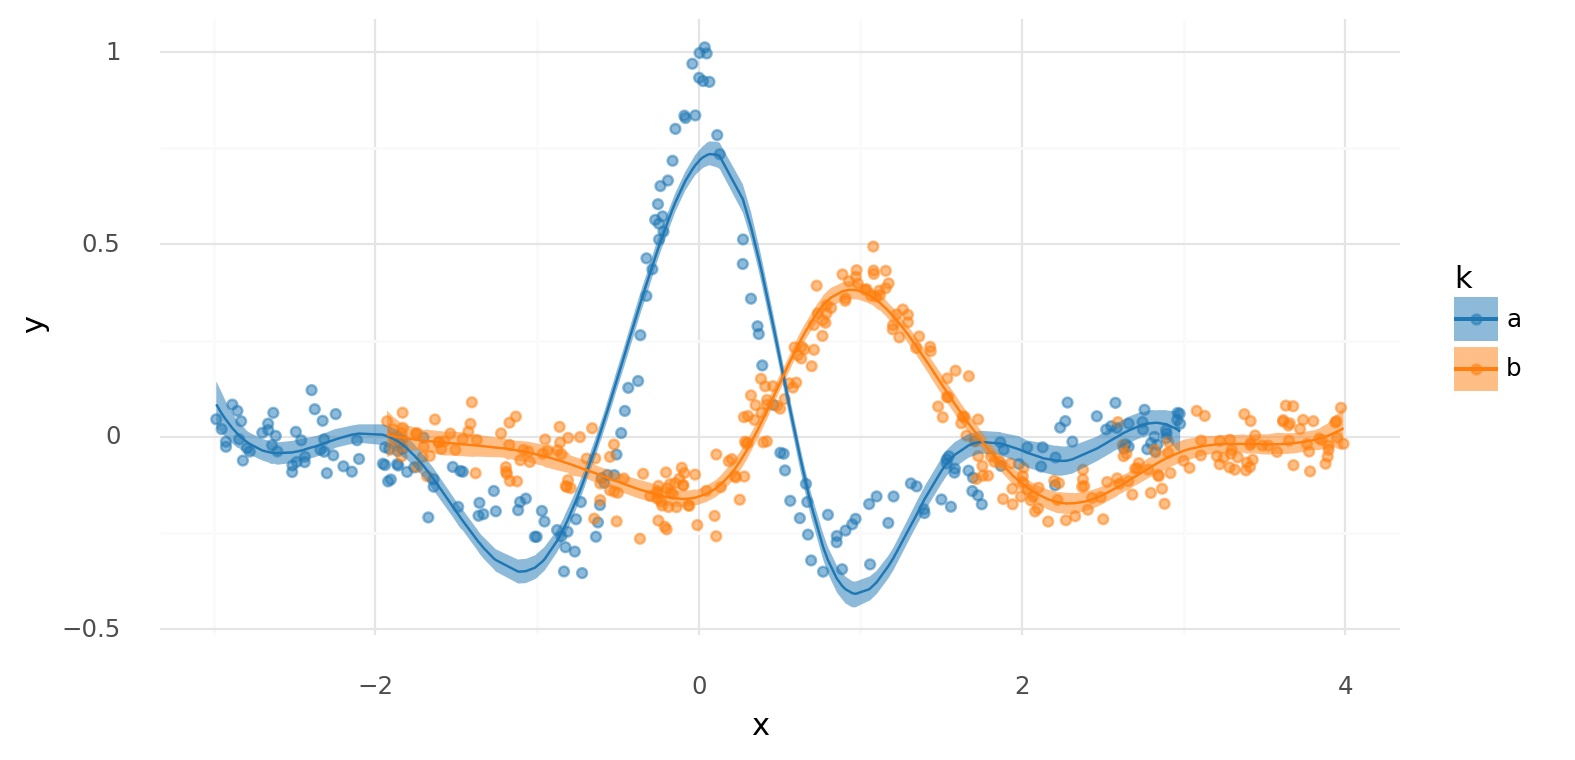

<ggplot: (338902643)>

In [69]:
_plot_posterior_mu(m4_trace, data=data2)

/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_48220/2876986528.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


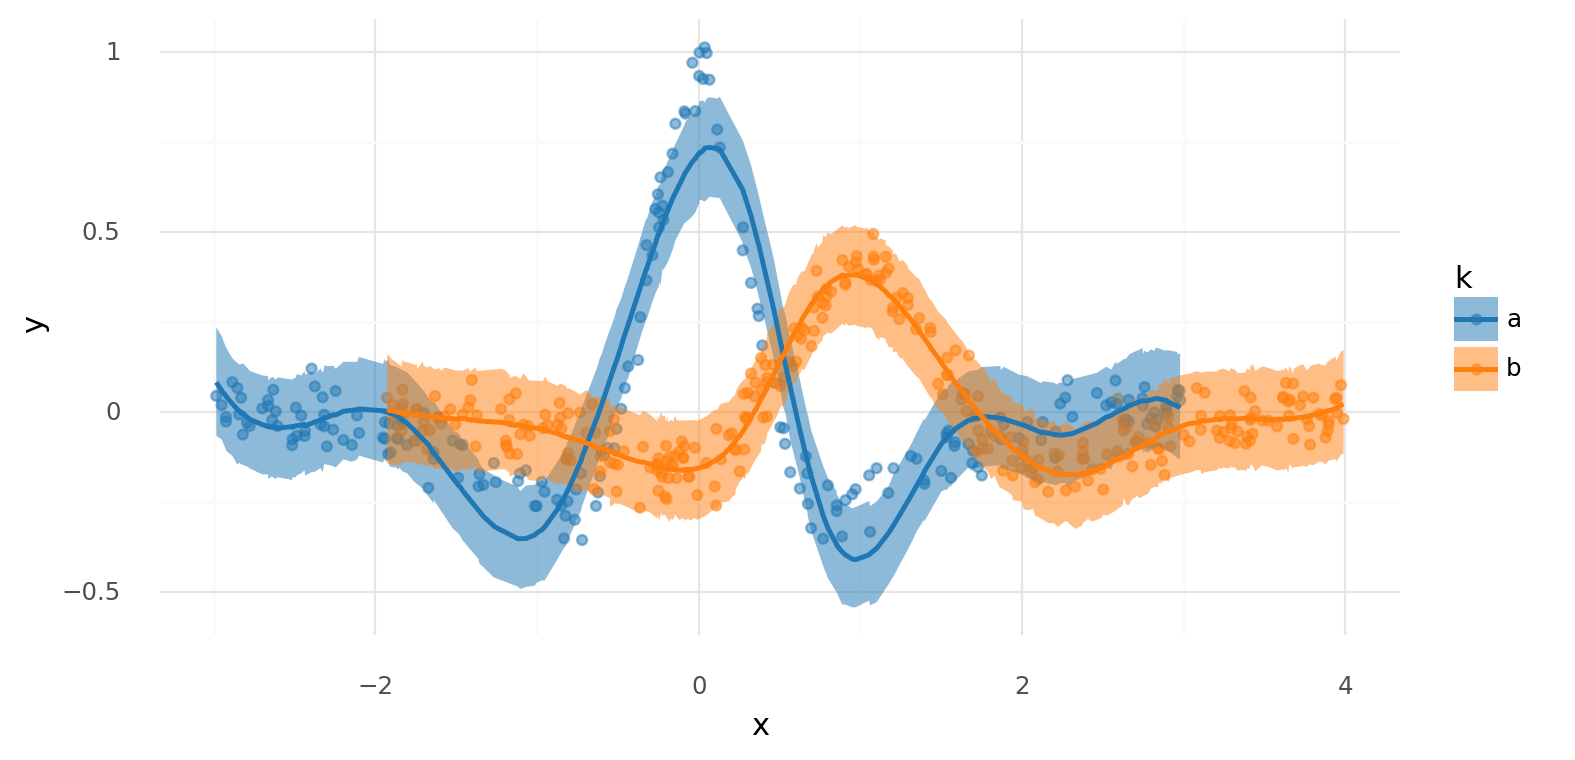

<ggplot: (342287032)>

In [70]:
_plot_ppc(m4_trace, data2)

### Out-of-distribution predictions

In [71]:
with build_model4(new_data3, B=new_B3_array):
    m4_post_pred_new = pm.sample_posterior_predictive(
        trace=m4_trace,
        var_names=["mu", "y"],
        return_inferencedata=True,
        extend_inferencedata=False,
    )

/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_48220/2876986528.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
/usr/local/Caskroom/miniconda/base/envs/speclet_pymcdev/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/Caskroom/miniconda/base/envs/speclet_pymcdev/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/Caskroom/miniconda/base/envs/speclet_pymcdev/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/Caskroom/miniconda/base/envs/

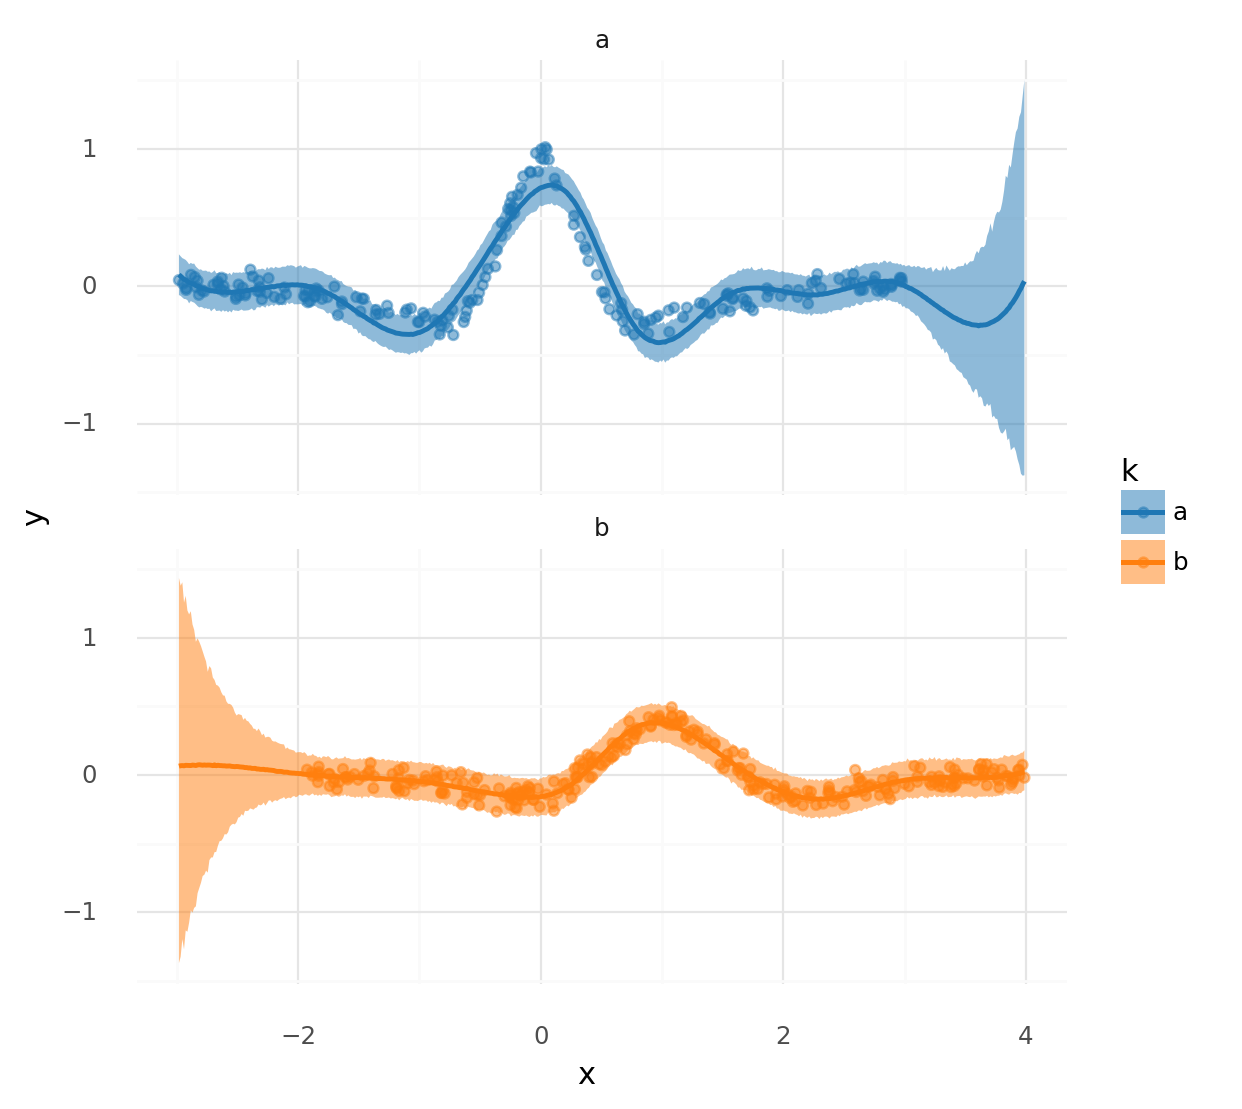

<ggplot: (339626265)>

In [72]:
(
    _plot_ppc(m4_post_pred_new, new_data3, pt_alpha=0)
    + gg.facet_wrap("~k", ncol=1)
    + gg.geom_point(gg.aes(x="x", y="y", color="k"), data=data2, alpha=0.5)
    + gg.theme(figure_size=(6, 6))
)

---

## Session info

In [73]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-02-18

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 8.0.1

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac

Git branch: add-nb-model

aesara    : 2.3.8
seaborn   : 0.11.2
numpy     : 1.22.2
plotnine  : 0.8.0
pandas    : 1.4.1
janitor   : 0.22.0
pymc      : 4.0.0b2
scipy     : 1.7.3
arviz     : 0.11.4
matplotlib: 3.5.1

